In [1]:
cd lag-llama

D:\jupyter\lag-llama-git\lag-llama


In [2]:
#pip install -r requirements.txt

In [3]:
#!pip install pandas==2.0.3
#!pip install gluonts==0.14.4

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir .

lag-llama.ckpt


In [5]:
from gluonts.torch import TemporalFusionTransformerEstimator, DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from sklearn.model_selection import train_test_split
from gluonts.dataset.pandas import PandasDataset
from tqdm.autonotebook import tqdm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from itertools import islice
import pandas as pd
import warnings
import torch

In [6]:
warnings.simplefilter("ignore", UserWarning)

In [7]:
dataset = pd.read_csv('../Top_Dataset/scraping/top_18_stock.csv', index_col=0, parse_dates=True)

# Best top 3
dataset = dataset.iloc[:, [0, 2, 10]]

In [8]:
dataset

BBCA  BMRI  AMRT
2020-02-03  32200  7500   815
2020-02-04  33000  7525   810
2020-02-05  33650  7700   810
2020-02-06  33700  7700   805
2020-02-07  33800  7725   800
...           ...   ...   ...
2024-06-03   9275  6100  2800
2024-06-04   9350  6150  2790
2024-06-05   9450  6000  2720
2024-06-06   9475  6175  2780
2024-06-07   9325  6275  2760

[1135 rows x 3 columns]

In [9]:
len(dataset)

1135

In [10]:
#total_data = len(dataset )
#train      = int(0.7 * total_data)
#test       = total_data - train_data

#train_data = data.iloc[:train]
#test_data  = data.iloc[test:]

# Splitting data training (70%), testing data (30%).
train_data, test_data = train_test_split(dataset, test_size=0.3, shuffle=False)

print("Train data:", len(train_data))
print("Test data:", len(test_data))

Train data: 794
Test data: 341


In [11]:
freq_1 = pd.infer_freq(train_data.index)
freq_2 = pd.infer_freq(test_data.index)

print(f"frequency used train data: {freq_1}")
print(f"frequency used test data: {freq_2}")

frequency used train data: B
frequency used test data: B


In [12]:
prediction_length =32
num_samples=20
batch_size=64
epoch=50

# **Function**

In [13]:
def preprocess_dataset(data):
    for col in data.columns:
        if data[col].dtype != 'object' and not pd.api.types.is_string_dtype(data[col]):
            data[col] = data[col].astype('float32')
    return PandasDataset(dict(data))

backtrain_dataset = preprocess_dataset(train_data)
backtest_dataset  = preprocess_dataset(test_data)

### Function Lag-Llama Zero-Shot

In [14]:
def lag_llama_zero_shot(context_length, use_rope_scaling):
    
    ckpt = torch.load("lag-llama.ckpt", map_location="cuda")
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        batch_size=batch_size,
        num_parallel_samples=num_samples
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_zero_shot_it, ts_zero_shot_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    zero_shot_forecasts = list(forecast_zero_shot_it)
    zero_shot_tss = list(ts_zero_shot_it)

    evaluator = Evaluator()
    agg_metrics, ts_metrics = evaluator(iter(zero_shot_tss), iter(zero_shot_forecasts))

    return zero_shot_forecasts, zero_shot_tss, agg_metrics

In [15]:
def print_crps_zero_shot(context_length, use_rope_scaling, agg_metrics):
    crps = agg_metrics['mean_wQuantileLoss']
    print(f"Lag-Llama Zero-Shot ({context_length}) rope_scaled ({use_rope_scaling}) CRPS: {crps:.4f}")
    return crps

### Function Lag-Llama Fine-Tuning

In [16]:
def lag_llama_fine_tuning(context_length, lr):
    ckpt = torch.load("lag-llama.ckpt", map_location="cuda")
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        nonnegative_pred_samples=True,
        
        aug_prob=0,
        lr=lr,
        
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],
        
        batch_size=batch_size,
        num_parallel_samples=num_samples,
        trainer_kwargs={"max_epochs": epoch},
    )

    predictor = estimator.train(
        backtrain_dataset,
        cache_data=True,
        shuffle_buffer_length=1000
    )

    fine_tuning_forecast_it, fine_tuning_ts_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=num_samples
    )

    fine_tuning_forecasts = list(fine_tuning_forecast_it)
    fine_tuning_tss = list(fine_tuning_ts_it)

    evaluator = Evaluator()
    agg_metrics, ts_metrics = evaluator(iter(fine_tuning_tss), iter(fine_tuning_forecasts))

    return fine_tuning_forecasts, fine_tuning_tss, agg_metrics

In [17]:
def print_crps_fine_tuning(context_length, lr, agg_metrics):
    crps = agg_metrics['mean_wQuantileLoss']
    print(f"Lag-Llama Fine-Tuning ({context_length}) Lr {lr} CRPS: {crps:.4f}")
    return crps

### Function Plotting

In [18]:
def plotting(forecasts, tss):
    plt.figure(figsize=(20, 15))
    date_formatter = mdates.DateFormatter('%d-%m-%Y')
    plt.rcParams.update({'font.size': 15})

    for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
        ax = plt.subplot(3, 3, idx+1)
        plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")
        forecast.plot(color='g')
        plt.xticks(rotation=60)
        ax.xaxis.set_major_formatter(date_formatter)
        ax.set_title(forecast.item_id)

    plt.gcf().tight_layout()
    plt.legend()
    plt.show()

# **Lag-Llama Zero-Shot**

## Zero-Shot Forecasting: Tuning the context length

### Get predictions with the default context length ***(32)***

In [19]:
forecasts_zero_shot_len_32_false, tss_zero_shot_len_32_false, agg_metrics = lag_llama_zero_shot(32, False)
zero_shot_len_32_false = print_crps_zero_shot(32, False, agg_metrics)

Running evaluation: 3it [00:00, 196.62it/s]

Lag-Llama Zero-Shot (32) rope_scaled (False) CRPS: 0.0364


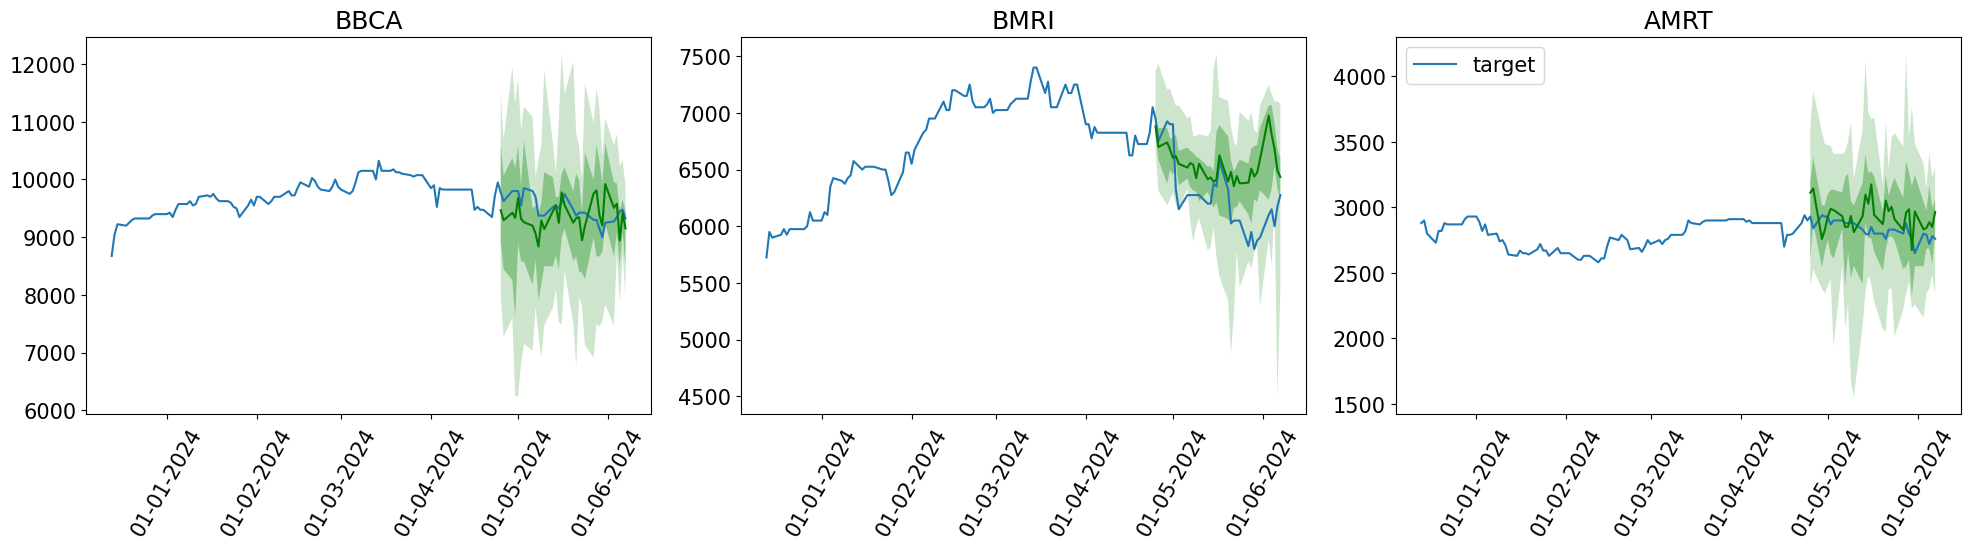

In [20]:
plotting(forecasts_zero_shot_len_32_false, tss_zero_shot_len_32_false)

### Get predictions with the default context length ***(64)***

In [21]:
forecasts_zero_shot_len_64_false, tss_zero_shot_len_64_false, agg_metrics = lag_llama_zero_shot(64, False)
zero_shot_len_64_false = print_crps_zero_shot(64, False, agg_metrics)

Running evaluation: 3it [00:00, 252.02it/s]

Lag-Llama Zero-Shot (64) rope_scaled (False) CRPS: 0.0395


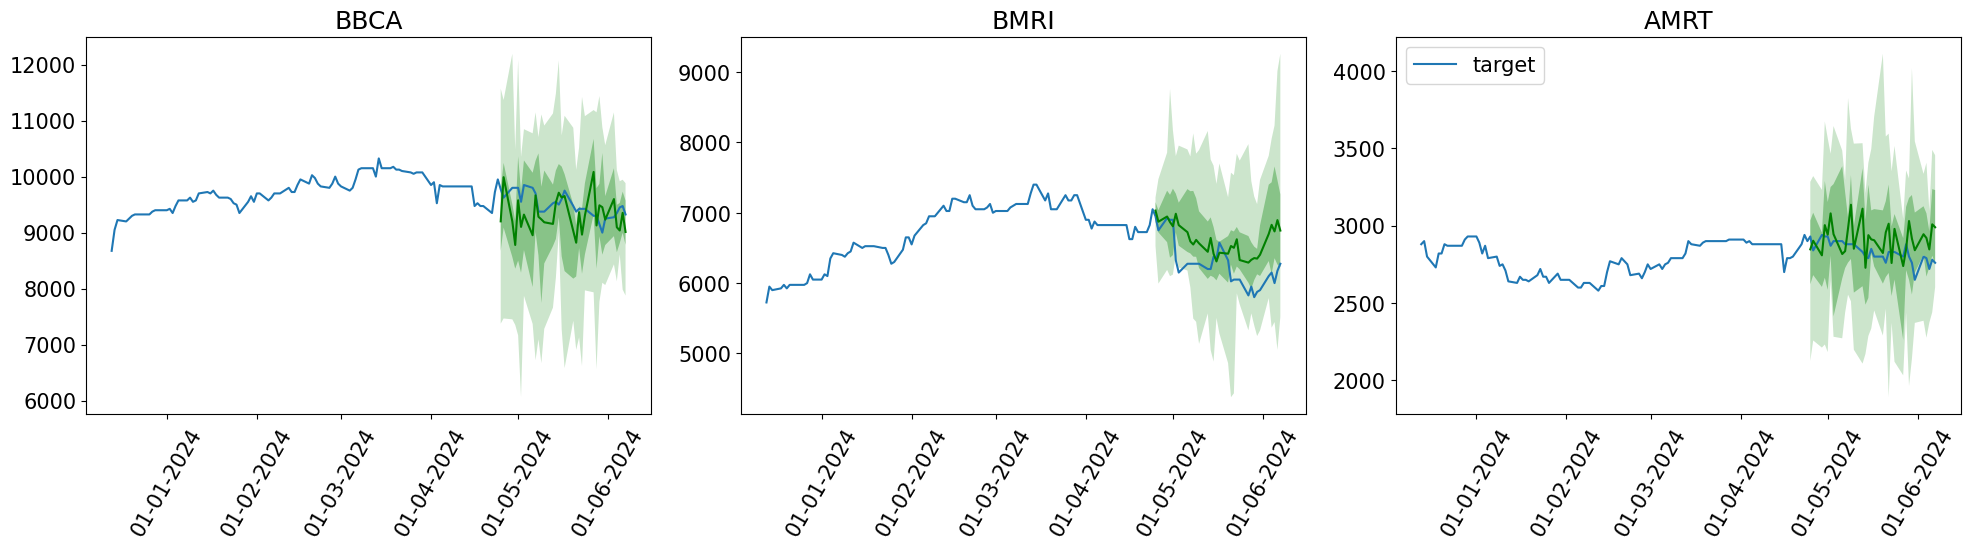

In [22]:
plotting(forecasts_zero_shot_len_64_false, tss_zero_shot_len_64_false)

Now enable **RoPE scaling** which better equips the model in handling large context lengths (larger than 32 in this case). This is done by passing `use_rope_scaling=True` to the `get_lag_llama_predictions` function.

In [23]:
forecasts_zero_shot_len_64_true, tss_zero_shot_len_64_true, agg_metrics = lag_llama_zero_shot(64, True)
zero_shot_len_64_true = print_crps_zero_shot(64, True, agg_metrics)

Running evaluation: 3it [00:00, 290.65it/s]

Lag-Llama Zero-Shot (64) rope_scaled (True) CRPS: 0.0417


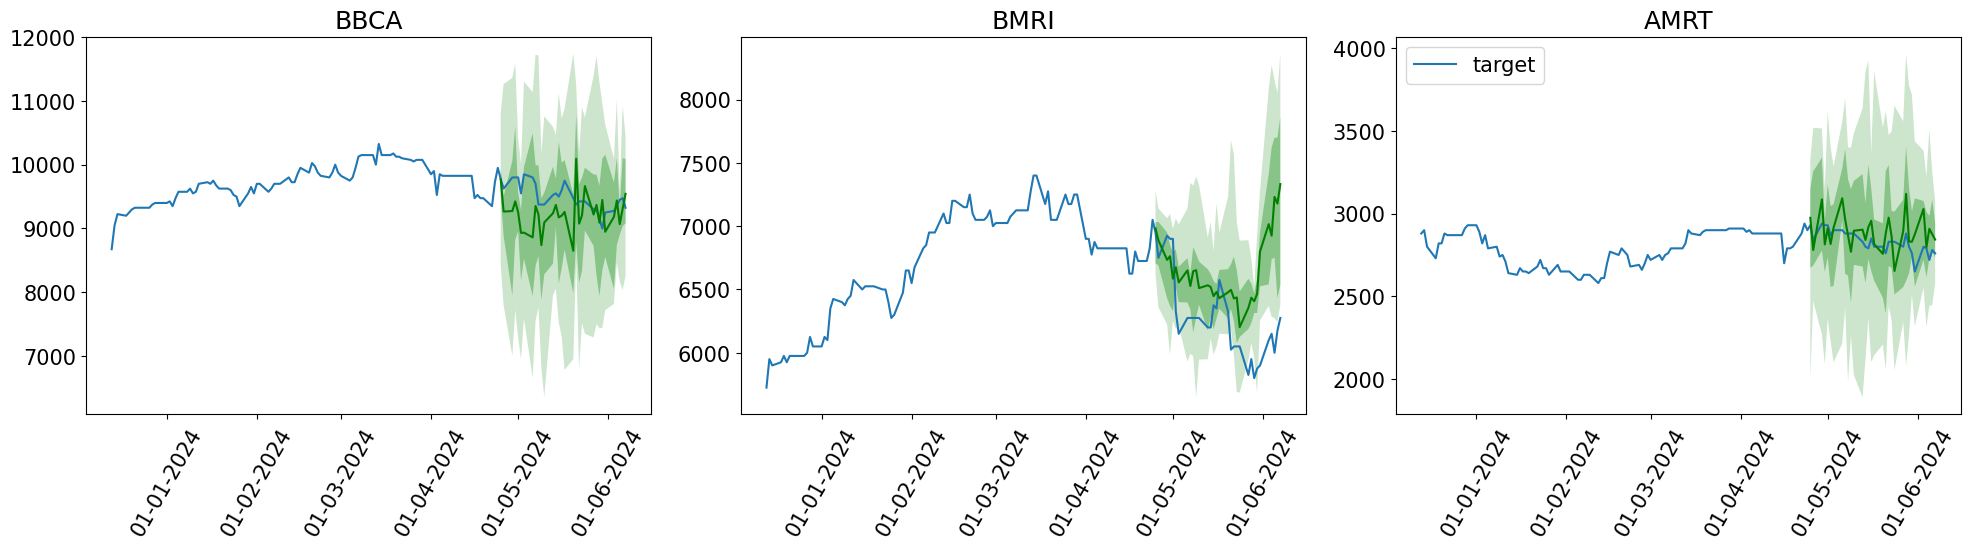

In [24]:
plotting(forecasts_zero_shot_len_64_true, tss_zero_shot_len_64_true)

### Get predictions with the default context length ***(128)***

In [25]:
forecasts_zero_shot_len_128_true, tss_zero_shot_len_128_true, agg_metrics = lag_llama_zero_shot(128, True)
zero_shot_len_128_true = print_crps_zero_shot(128, True, agg_metrics)

Running evaluation: 3it [00:00, 426.54it/s]

Lag-Llama Zero-Shot (128) rope_scaled (True) CRPS: 0.0413


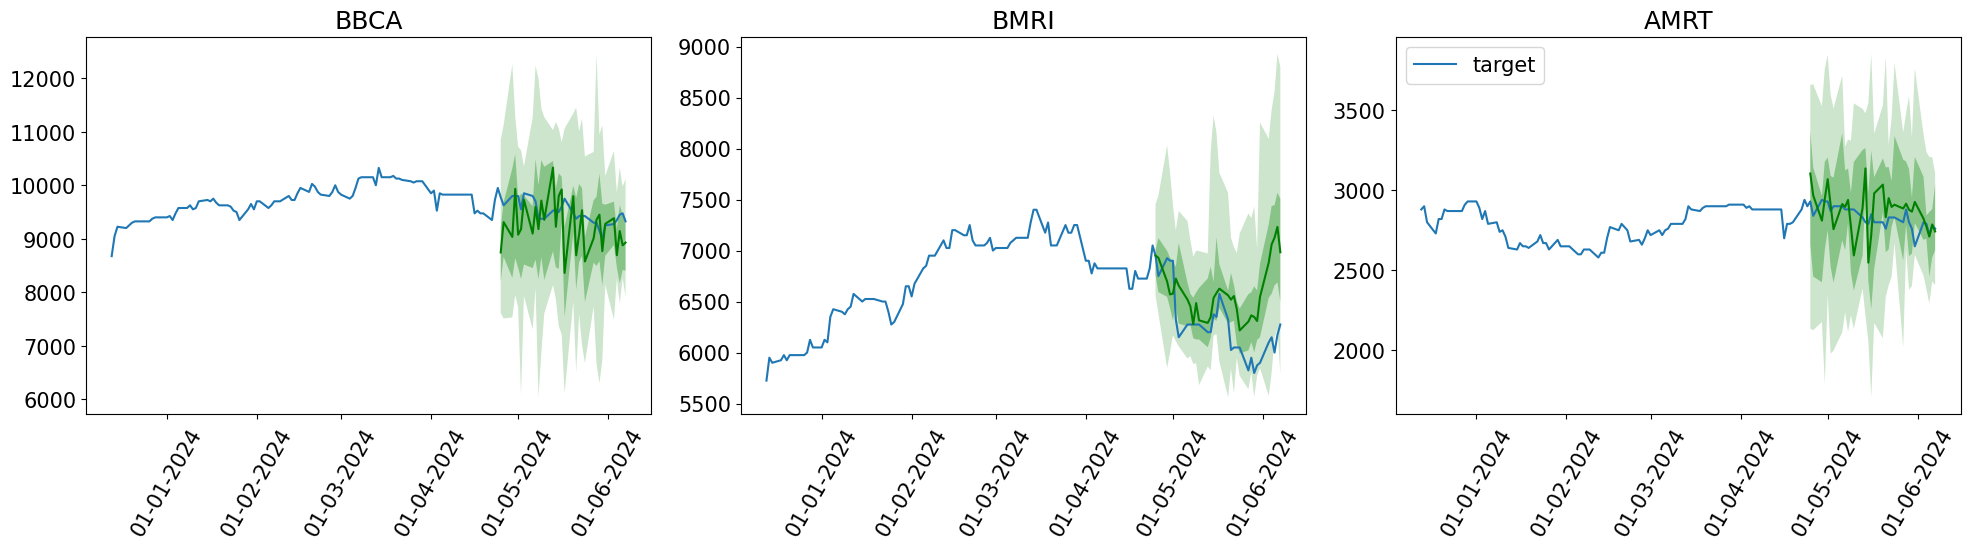

In [26]:
plotting(forecasts_zero_shot_len_128_true, tss_zero_shot_len_128_true)

### Get predictions with the default context length ***(256)***

In [27]:
forecasts_zero_shot_len_256_true, tss_zero_shot_len_256_true, agg_metrics = lag_llama_zero_shot(256, True)
zero_shot_len_256_true = print_crps_zero_shot(256, True, agg_metrics)

Running evaluation: 3it [00:00, 287.29it/s]

Lag-Llama Zero-Shot (256) rope_scaled (True) CRPS: 0.0379


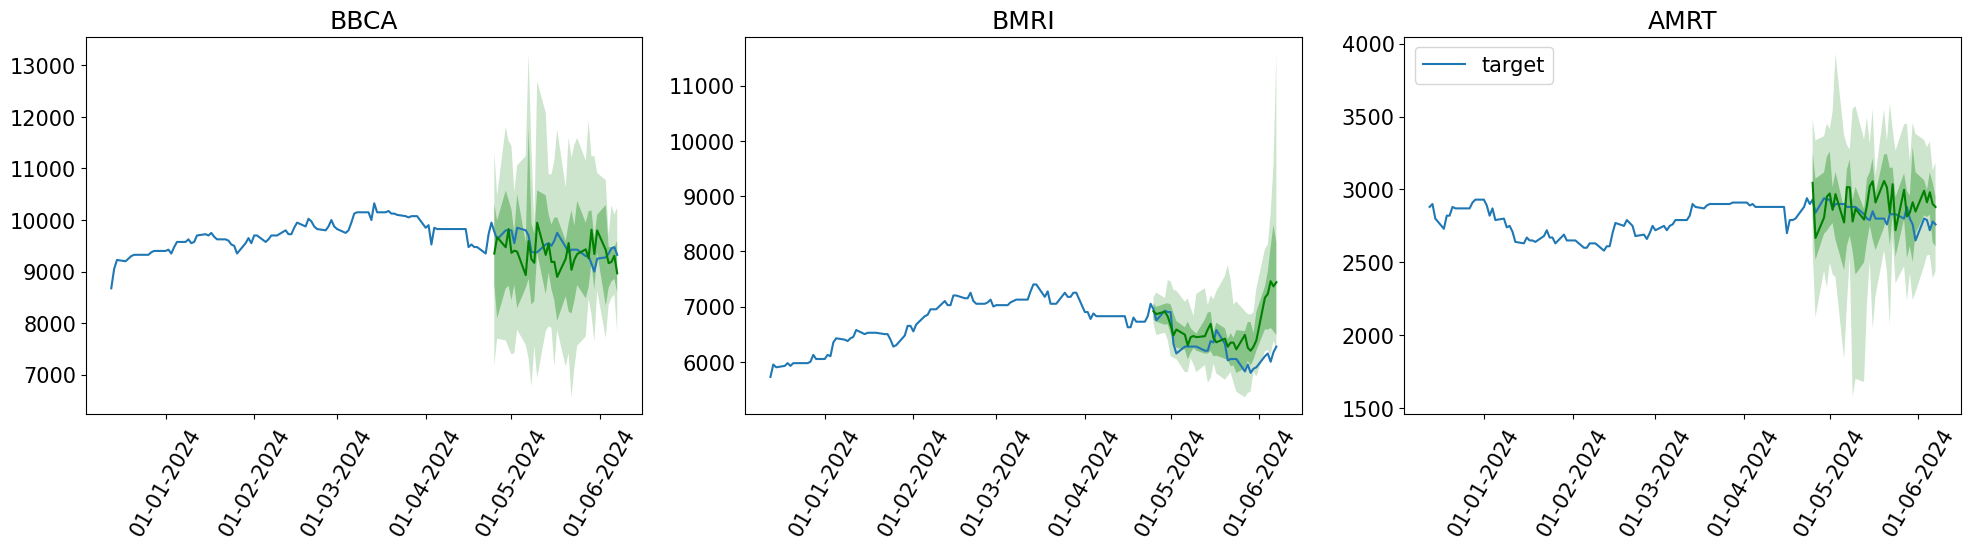

In [28]:
plotting(forecasts_zero_shot_len_256_true, tss_zero_shot_len_256_true)

### Get predictions with the default context length ***(512)***

In [29]:
forecasts_zero_shot_len_512_true, tss_zero_shot_len_512_true, agg_metrics = lag_llama_zero_shot(512, True)
zero_shot_len_512_true = print_crps_zero_shot(512, True, agg_metrics)

Running evaluation: 3it [00:00, 199.16it/s]

Lag-Llama Zero-Shot (512) rope_scaled (True) CRPS: 0.0681


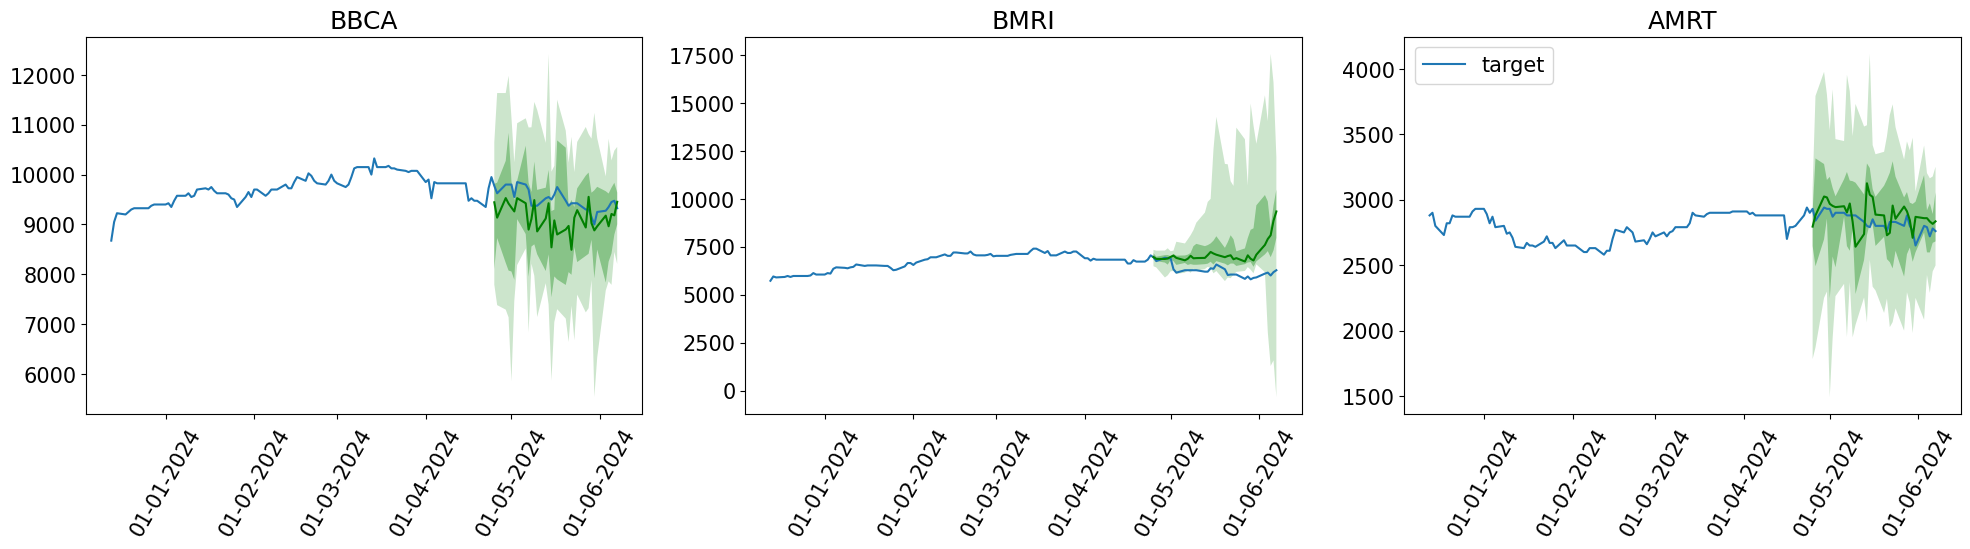

In [30]:
plotting(forecasts_zero_shot_len_512_true, tss_zero_shot_len_512_true)

### Get predictions with the default context length ***(1024)***

In [31]:
forecasts_zero_shot_len_1024_true, tss_zero_shot_len_1024_true, agg_metrics = lag_llama_zero_shot(1024, True)
zero_shot_len_1024_true = print_crps_zero_shot(1024, True, agg_metrics)

Running evaluation: 3it [00:00, 257.33it/s]

Lag-Llama Zero-Shot (1024) rope_scaled (True) CRPS: 0.1107


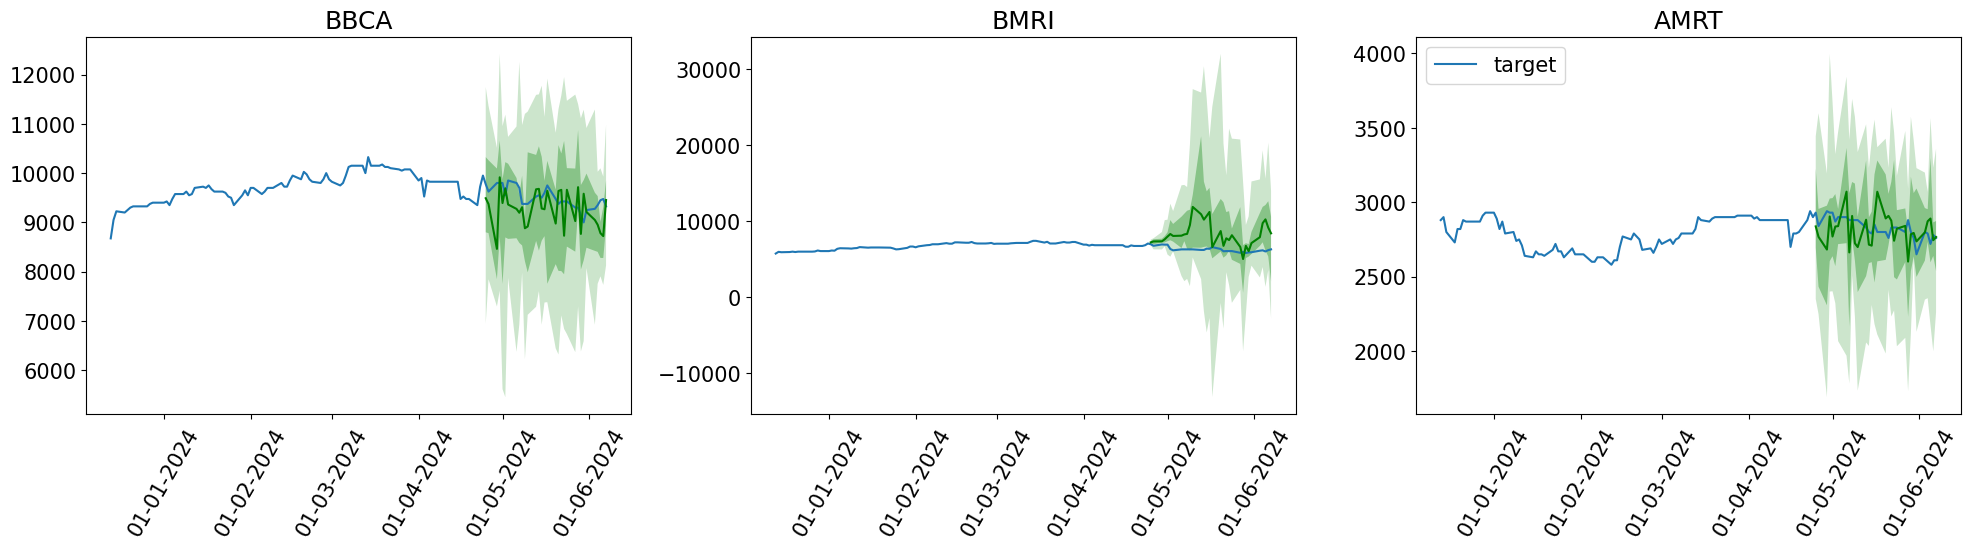

In [32]:
plotting(forecasts_zero_shot_len_1024_true, tss_zero_shot_len_1024_true)

# **Lag-Llama Fine-Tuning**

### ***Learning Rate 1e-2***

### Get predictions with the default context length ***(32)***

In [33]:
forecasts_fine_tuning_len_32_lr_1e_2, tss_fine_tuning_len_32_lr_1e_2, agg_metrics = lag_llama_fine_tuning(32, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.25031 (best 10.25031), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_371\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.07286 (best 9.07286), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_371\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 9.06660 (best 9.06660), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_371\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.66825 (best 8.66825), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_371\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 8.37527 (best 8.37527), saving model 

In [34]:
fine_tuning_len_32_lr_1e_2 = print_crps_fine_tuning(32, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.01 CRPS: 0.0195


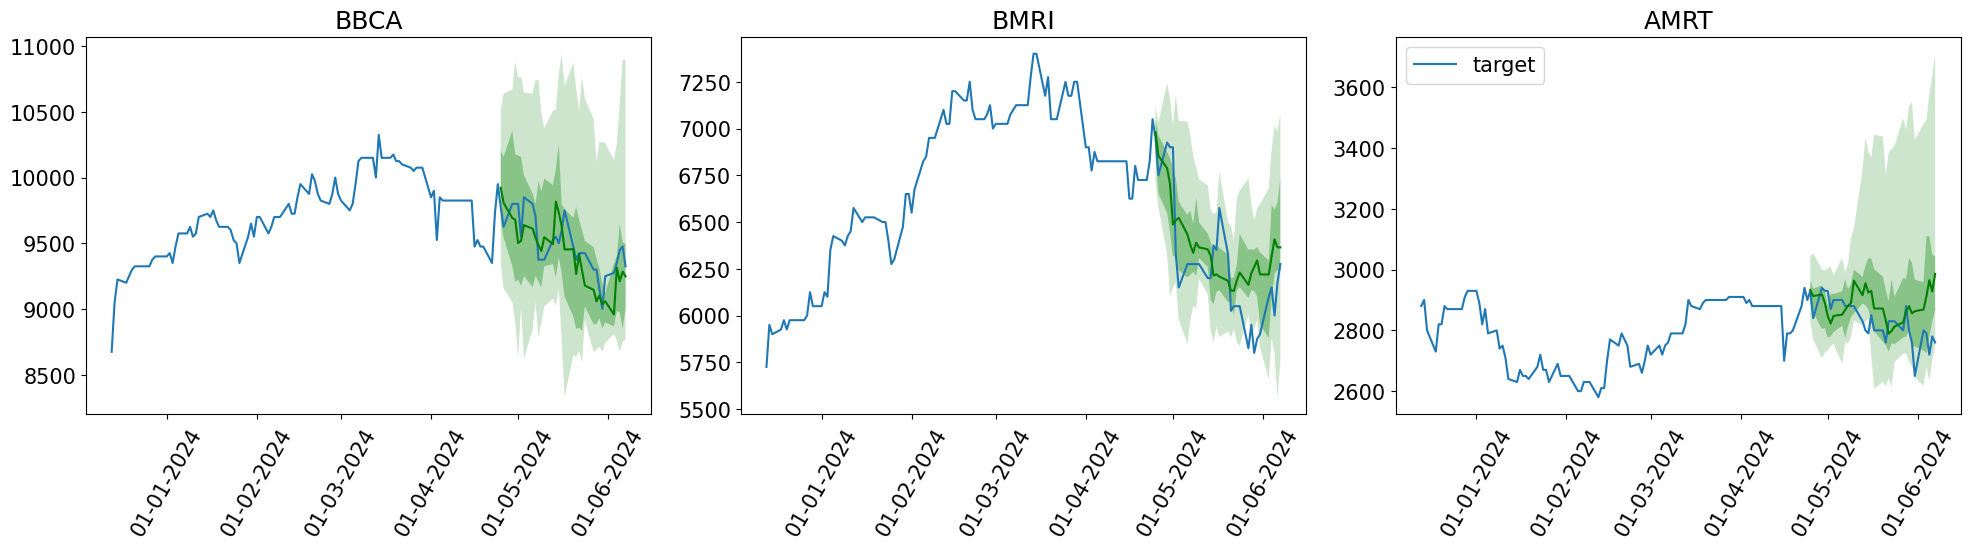

In [35]:
plotting(forecasts_fine_tuning_len_32_lr_1e_2, tss_fine_tuning_len_32_lr_1e_2)

### Get predictions with the default context length ***(64)***

In [36]:
forecasts_fine_tuning_len_64_lr_1e_2, tss_fine_tuning_len_64_lr_1e_2, agg_metrics = lag_llama_fine_tuning(64, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.95251 (best 9.95251), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_372\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.04953 (best 9.04953), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_372\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 8.97543 (best 8.97543), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_372\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.90197 (best 8.90197), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_372\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 8.44509 (best 8.44509), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [37]:
fine_tuning_len_64_lr_1e_2 = print_crps_fine_tuning(64, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.01 CRPS: 0.2130


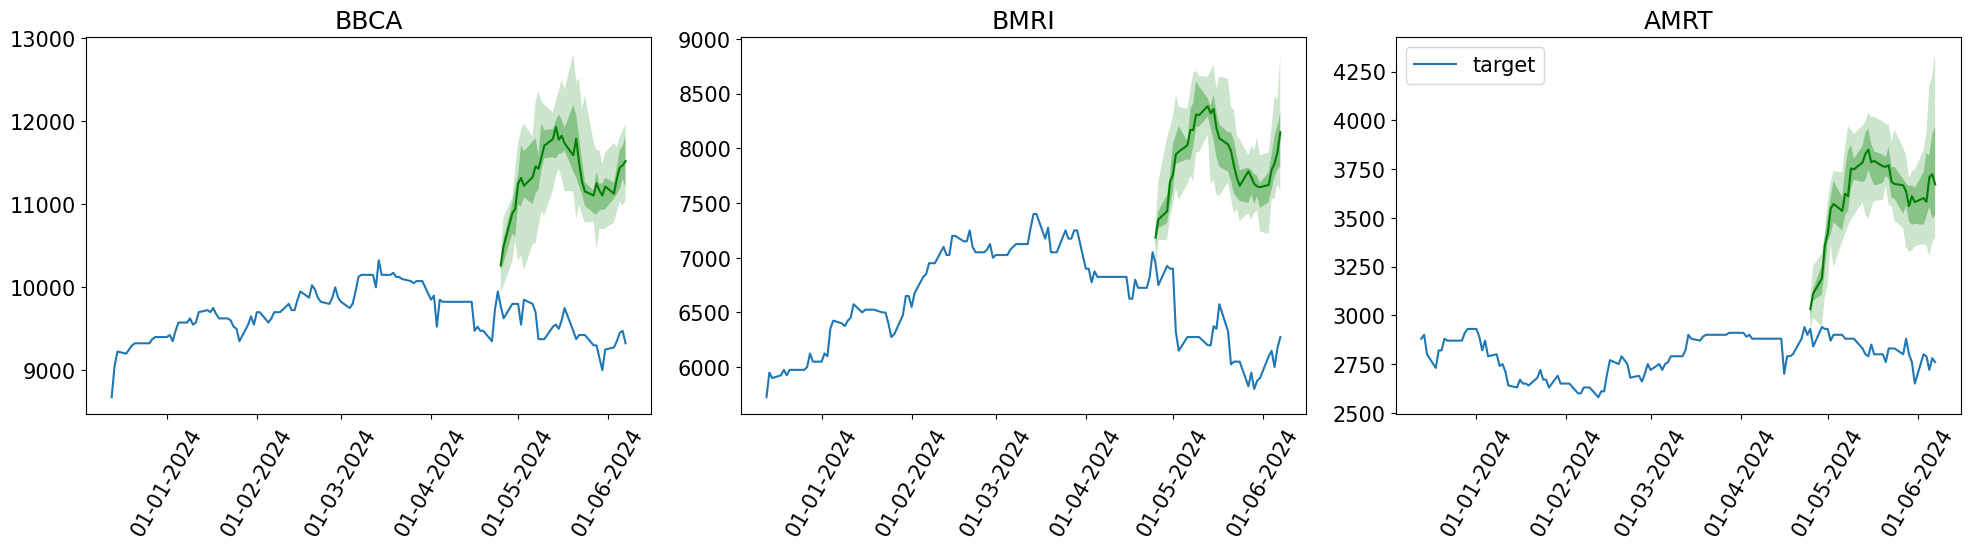

In [38]:
plotting(forecasts_fine_tuning_len_64_lr_1e_2, tss_fine_tuning_len_64_lr_1e_2)

### Get predictions with the default context length ***(128)***

In [39]:
forecasts_fine_tuning_len_128_lr_1e_2, tss_fine_tuning_len_128_lr_1e_2, agg_metrics = lag_llama_fine_tuning(128, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.80859 (best 9.80859), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_373\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.98070 (best 8.98070), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_373\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 8.64600 (best 8.64600), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_373\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 8.32732 (best 8.32732), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_373\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 8.09154 (best 8.09154), saving model to

In [40]:
fine_tuning_len_128_lr_1e_2 = print_crps_fine_tuning(128, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.01 CRPS: 0.0928


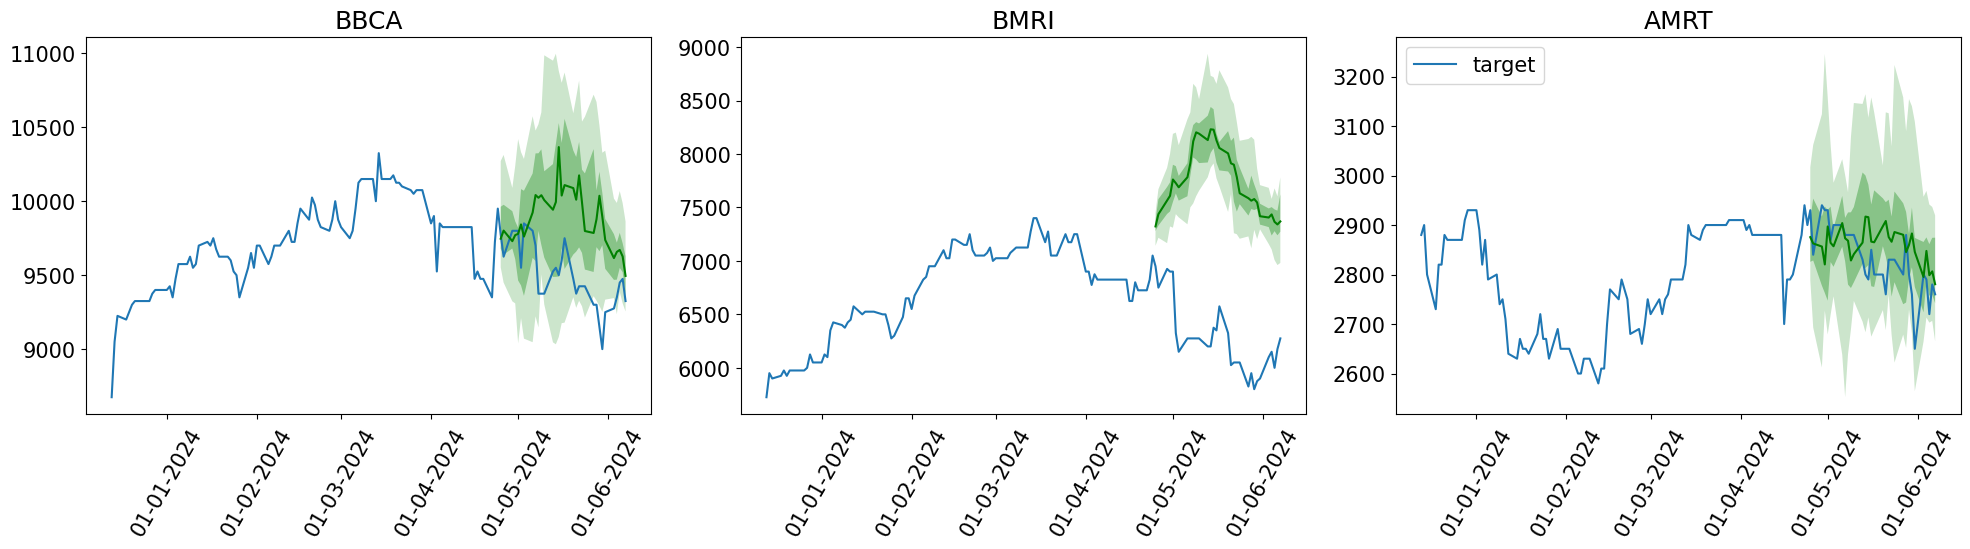

In [41]:
plotting(forecasts_fine_tuning_len_128_lr_1e_2, tss_fine_tuning_len_128_lr_1e_2)

### Get predictions with the default context length ***(256)***

In [42]:
forecasts_fine_tuning_len_256_lr_1e_2, tss_fine_tuning_len_256_lr_1e_2, agg_metrics = lag_llama_fine_tuning(256, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.63529 (best 9.63529), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_374\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.77229 (best 8.77229), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_374\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 8.48425 (best 8.48425), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_374\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 8.09650 (best 8.09650), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_374\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 7.94931 (best 7.94931), saving model to

In [43]:
fine_tuning_len_256_lr_1e_2 = print_crps_fine_tuning(256, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.01 CRPS: 0.0445


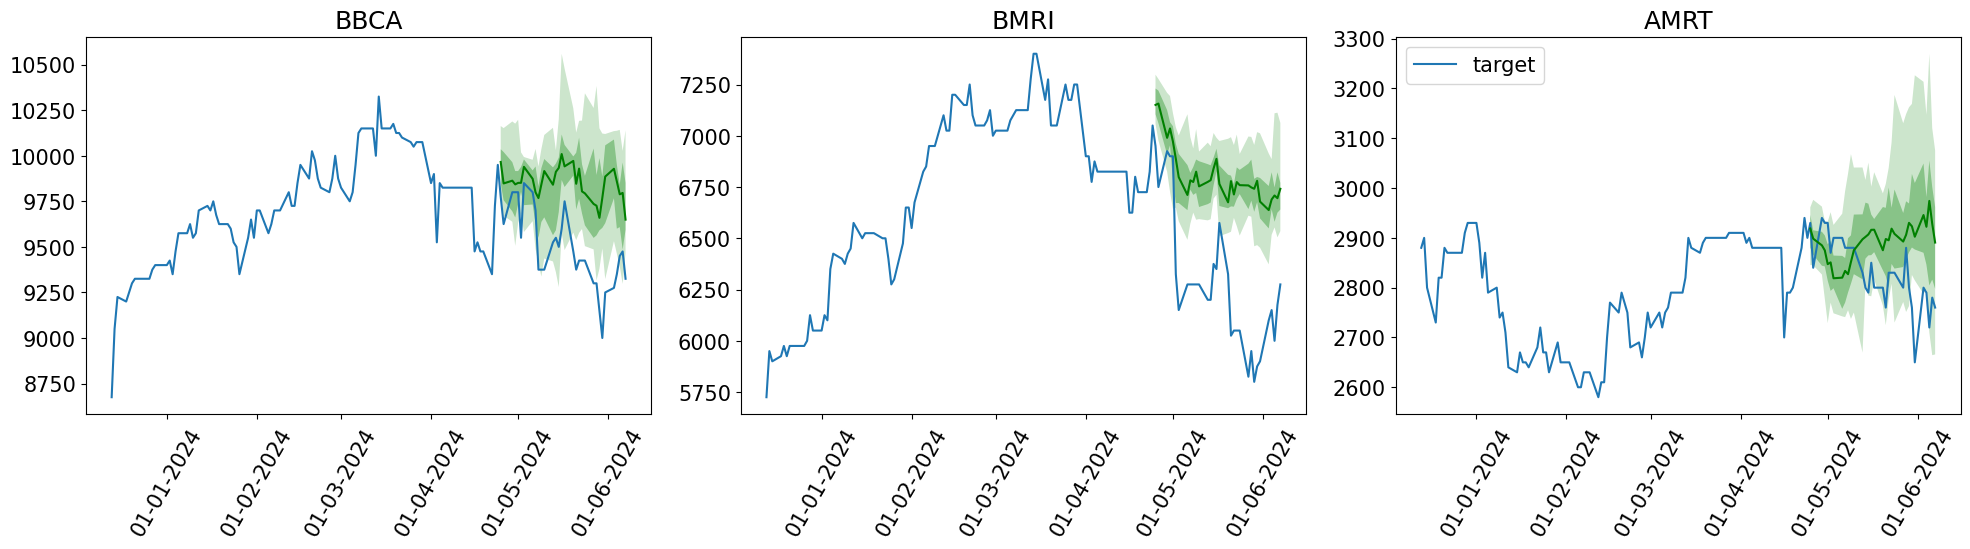

In [44]:
plotting(forecasts_fine_tuning_len_256_lr_1e_2, tss_fine_tuning_len_256_lr_1e_2)

### Get predictions with the default context length ***(512)***

In [45]:
forecasts_fine_tuning_len_512_lr_1e_2, tss_fine_tuning_len_512_lr_1e_2, agg_metrics = lag_llama_fine_tuning(512, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.18322 (best 10.18322), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_375\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.74665 (best 8.74665), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_375\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 8.64384 (best 8.64384), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_375\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 8.64139 (best 8.64139), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_375\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 8.22967 (best 8.22967), saving model 

In [46]:
fine_tuning_len_512_lr_1e_2 = print_crps_fine_tuning(512, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.01 CRPS: 0.1919


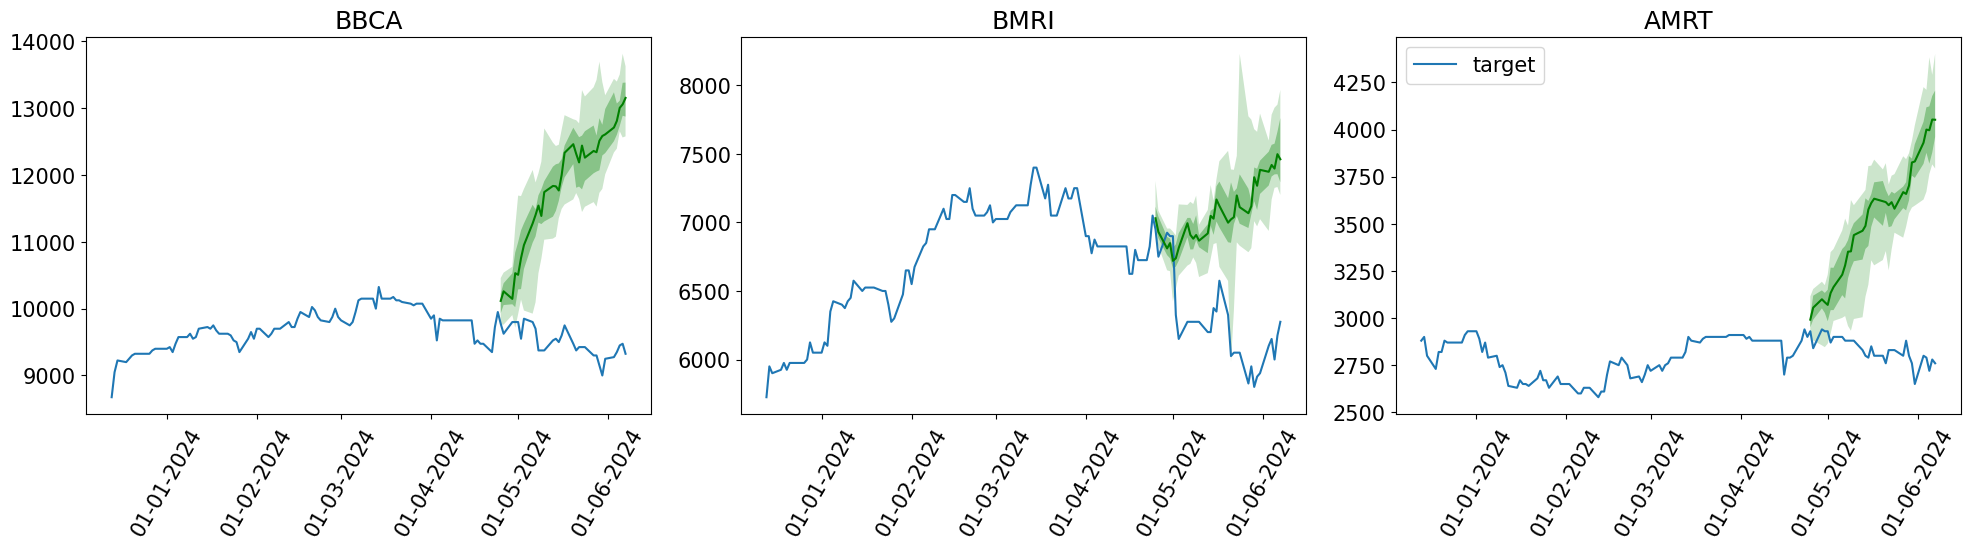

In [47]:
plotting(forecasts_fine_tuning_len_512_lr_1e_2, tss_fine_tuning_len_512_lr_1e_2)

### Get predictions with the default context length ***(1024)***

In [48]:
forecasts_fine_tuning_len_1024_lr_1e_2, tss_fine_tuning_len_1024_lr_1e_2, agg_metrics = lag_llama_fine_tuning(1024, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.48252 (best 9.48252), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_376\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.82481 (best 8.82481), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_376\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.82020 (best 8.82020), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_376\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.69628 (best 8.69628), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_376\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 8.56081 (best 8.56081), saving model to

In [49]:
fine_tuning_len_1024_lr_1e_2 = print_crps_fine_tuning(1024, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.01 CRPS: 0.0367


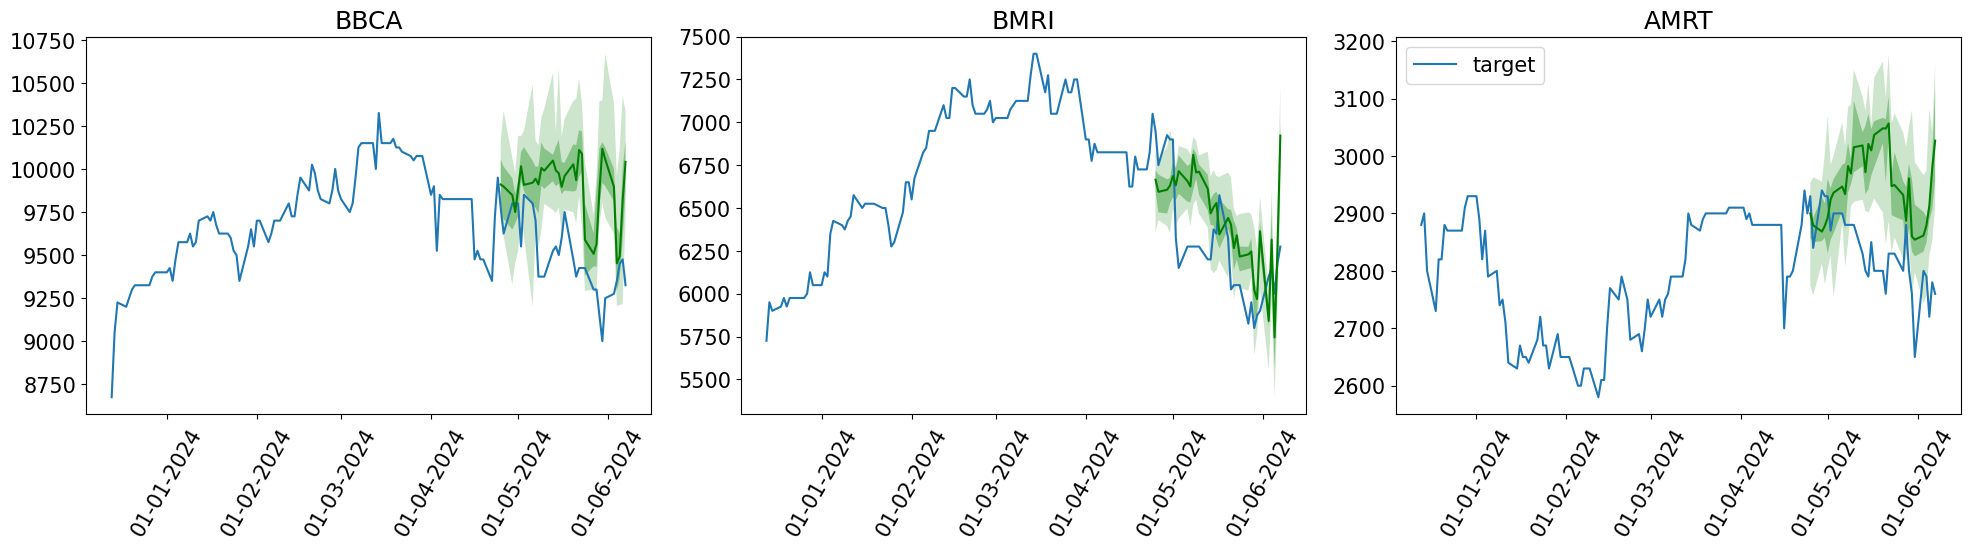

In [50]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_2, tss_fine_tuning_len_1024_lr_1e_2)

### ***Learning Rate 1e-3***

### Get predictions with the default context length ***(32)***

In [51]:
forecasts_fine_tuning_len_32_lr_1e_3, tss_fine_tuning_len_32_lr_1e_3, agg_metrics = lag_llama_fine_tuning(32, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.22665 (best 10.22665), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_382\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.48247 (best 8.48247), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_382\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.39840 (best 8.39840), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_382\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.70567 (best 7.70567), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_382\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 7.69995 (best 7.69995), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_log

In [52]:
fine_tuning_len_32_lr_1e_3 = print_crps_fine_tuning(32, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.001 CRPS: 0.0327


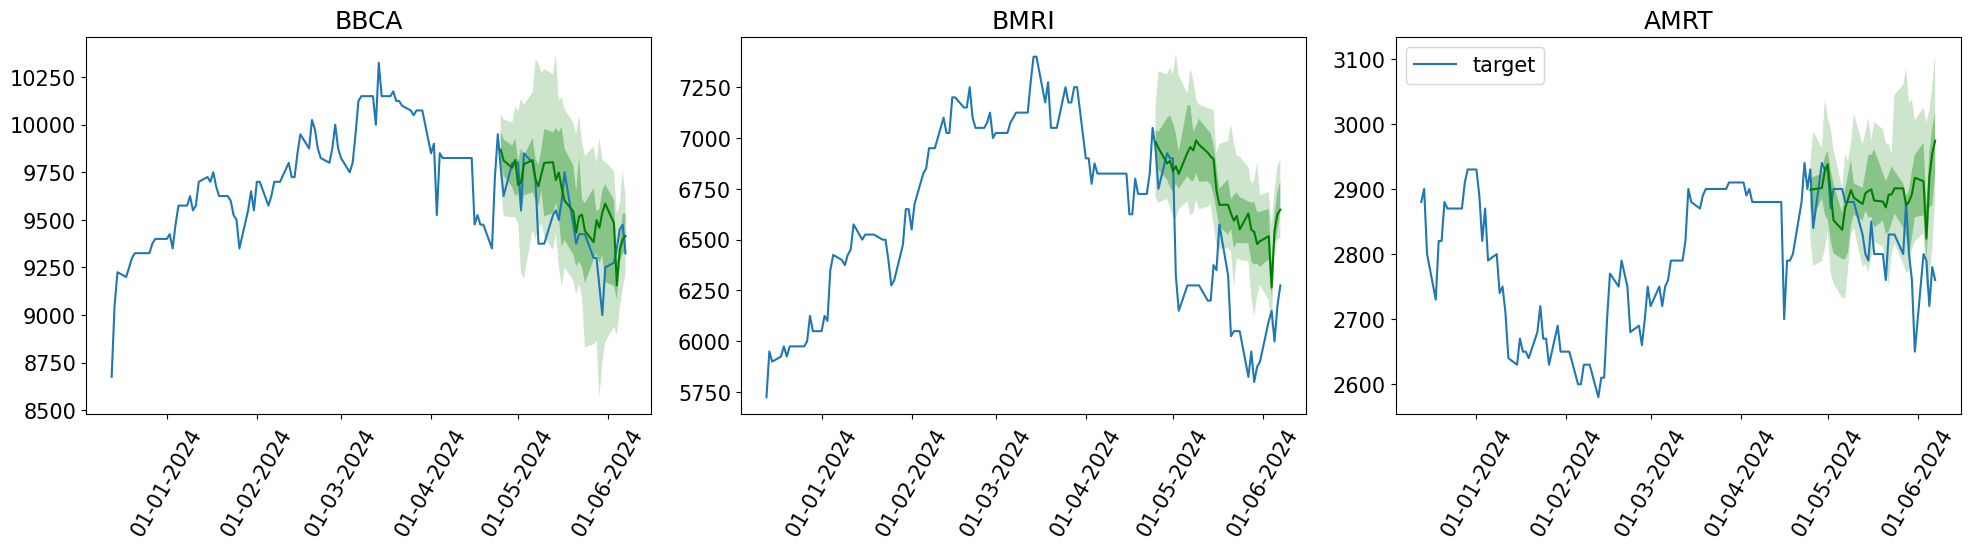

In [53]:
plotting(forecasts_fine_tuning_len_32_lr_1e_3, tss_fine_tuning_len_32_lr_1e_3)

### Get predictions with the default context length ***(64)***

In [54]:
forecasts_fine_tuning_len_64_lr_1e_3, tss_fine_tuning_len_64_lr_1e_3, agg_metrics = lag_llama_fine_tuning(64, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.91592 (best 9.91592), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_383\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.40948 (best 8.40948), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_383\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.72105 (best 7.72105), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_383\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.59470 (best 7.59470), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_383\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.48069 (best 7.48069), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_383\\checkpoints\\epoch=4-step=250.ckpt' as top

In [55]:
fine_tuning_len_64_lr_1e_3 = print_crps_fine_tuning(64, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.001 CRPS: 0.1018


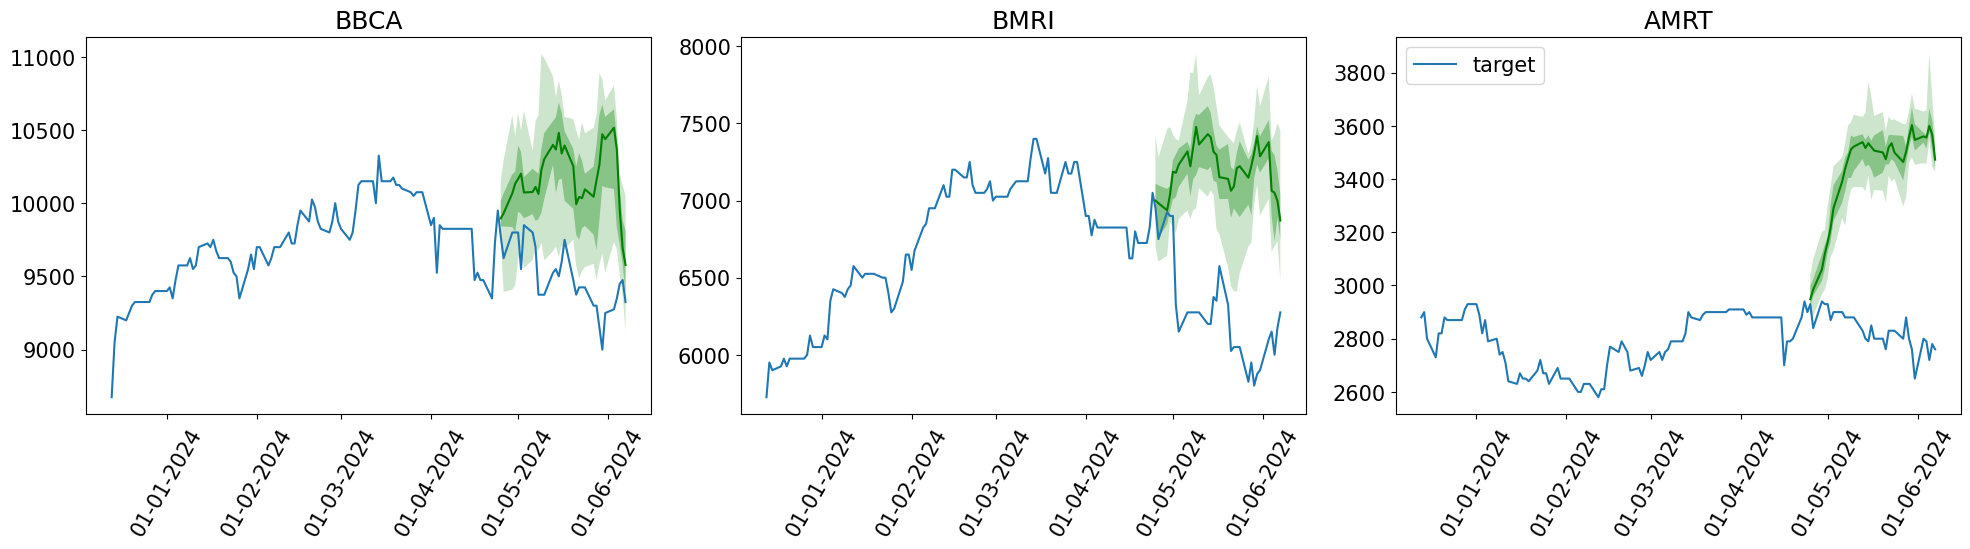

In [56]:
plotting(forecasts_fine_tuning_len_64_lr_1e_3, tss_fine_tuning_len_64_lr_1e_3)

### Get predictions with the default context length ***(128)***

In [57]:
forecasts_fine_tuning_len_128_lr_1e_3, tss_fine_tuning_len_128_lr_1e_3, agg_metrics = lag_llama_fine_tuning(128, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.86461 (best 10.86461), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_385\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.74293 (best 8.74293), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_385\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.46876 (best 8.46876), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_385\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.70455 (best 7.70455), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_385\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 7.27937 (best 7.27937), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_log

In [58]:
fine_tuning_len_128_lr_1e_3 = print_crps_fine_tuning(128, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.001 CRPS: 0.1898


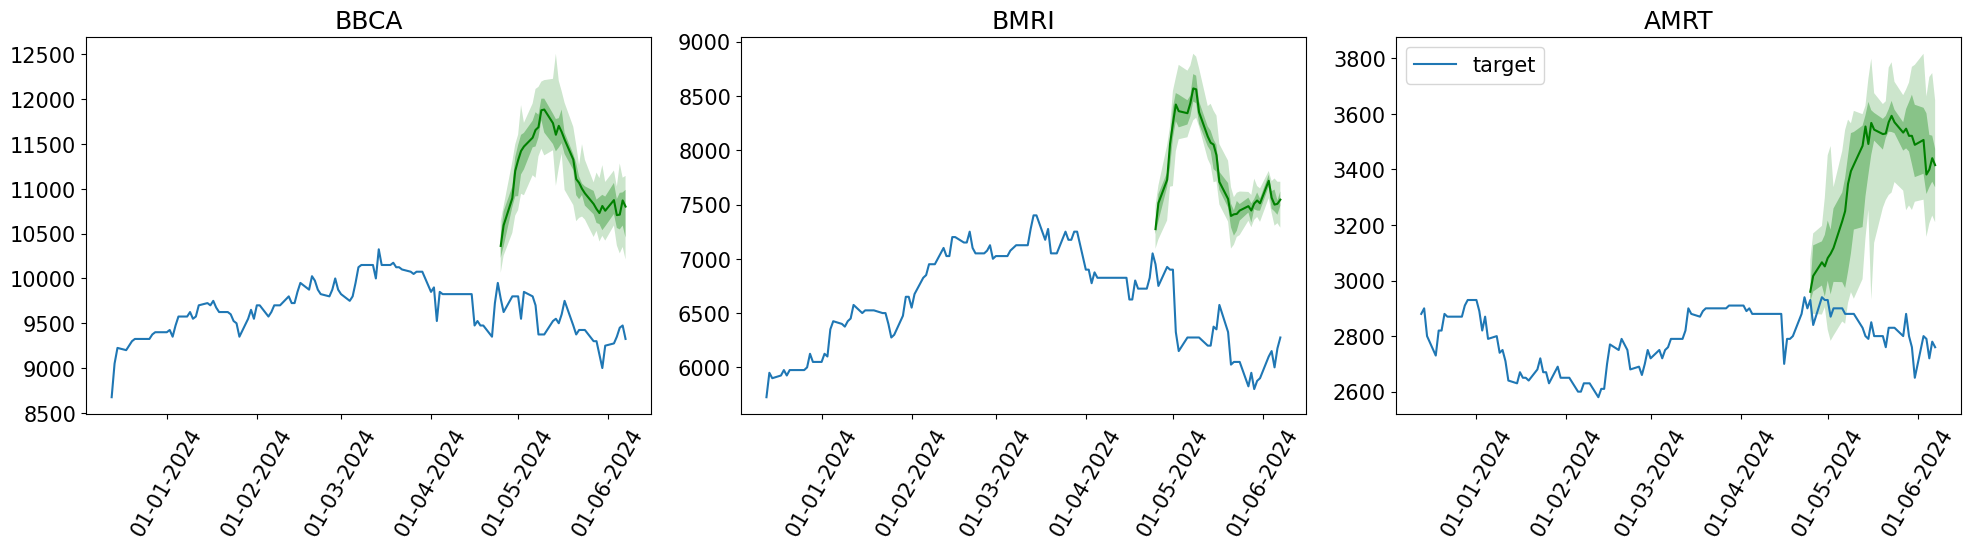

In [59]:
plotting(forecasts_fine_tuning_len_128_lr_1e_3, tss_fine_tuning_len_128_lr_1e_3)

### Get predictions with the default context length ***(256)***

In [60]:
forecasts_fine_tuning_len_256_lr_1e_3, tss_fine_tuning_len_256_lr_1e_3, agg_metrics = lag_llama_fine_tuning(256, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.74591 (best 10.74591), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_386\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.47284 (best 8.47284), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_386\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.08811 (best 8.08811), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_386\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.48757 (best 7.48757), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_386\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 7.37572 (best 7.37572), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_log

In [61]:
fine_tuning_len_256_lr_1e_3 = print_crps_fine_tuning(256, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.001 CRPS: 0.1119


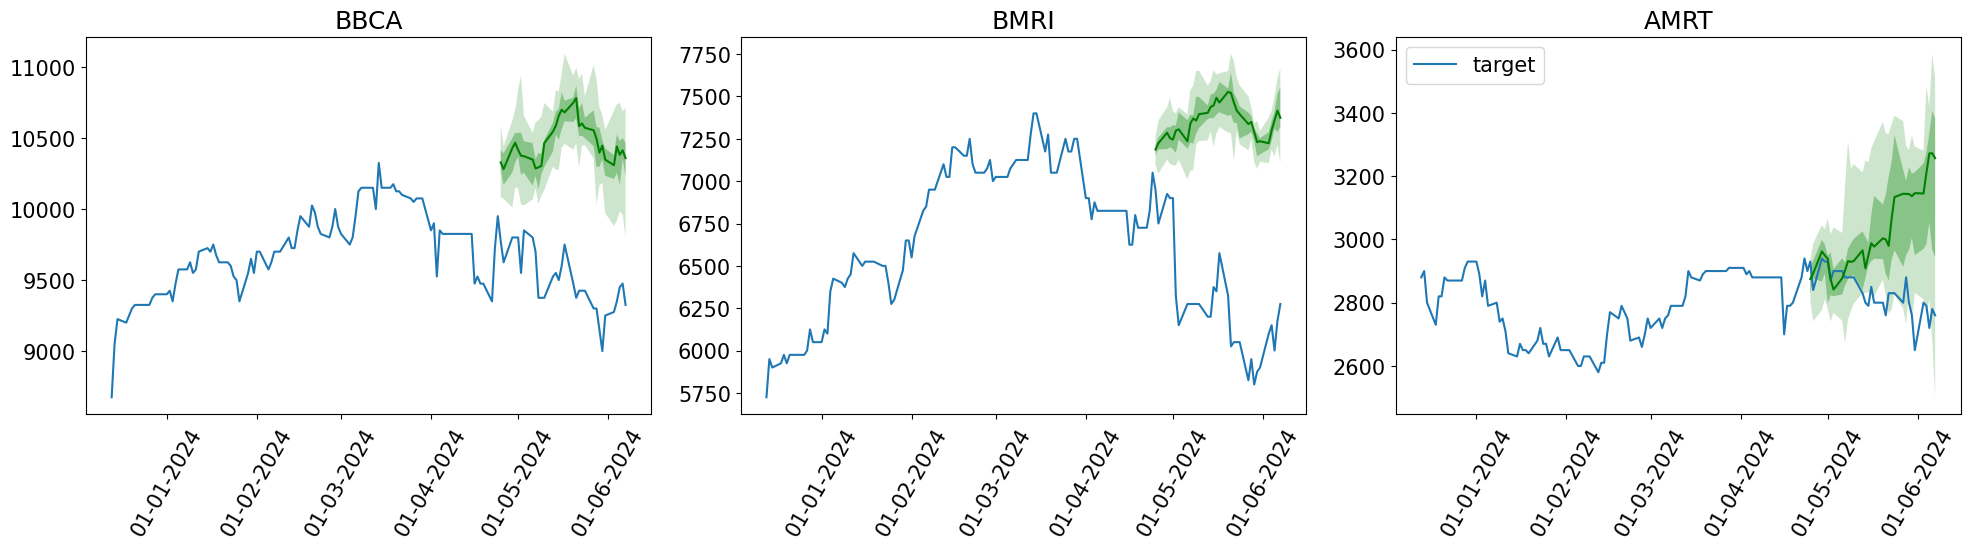

In [62]:
plotting(forecasts_fine_tuning_len_256_lr_1e_3, tss_fine_tuning_len_256_lr_1e_3)

### Get predictions with the default context length ***(512)***

In [63]:
forecasts_fine_tuning_len_512_lr_1e_3, tss_fine_tuning_len_512_lr_1e_3, agg_metrics = lag_llama_fine_tuning(512, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.64922 (best 9.64922), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_387\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.26472 (best 8.26472), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_387\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.54056 (best 7.54056), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_387\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 7.22886 (best 7.22886), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_387\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 7.04547 (best 7.04547), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [64]:
fine_tuning_len_512_lr_1e_3 = print_crps_fine_tuning(512, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.001 CRPS: 0.1354


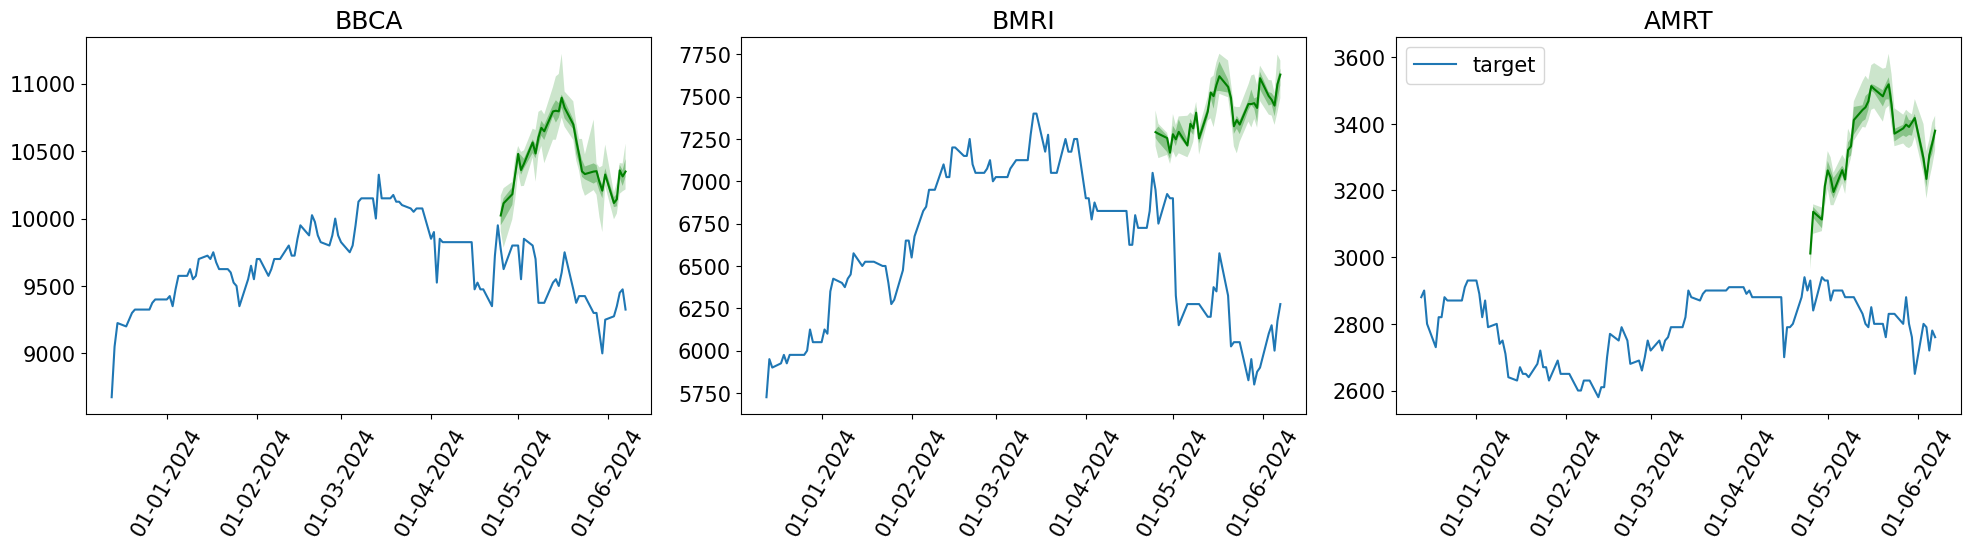

In [65]:
plotting(forecasts_fine_tuning_len_512_lr_1e_3, tss_fine_tuning_len_512_lr_1e_3)

### Get predictions with the default context length ***(1024)***

In [66]:
forecasts_fine_tuning_len_1024_lr_1e_3, tss_fine_tuning_len_1024_lr_1e_3, agg_metrics = lag_llama_fine_tuning(1024, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.85052 (best 8.85052), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_388\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.71220 (best 8.71220), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_388\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.97430 (best 7.97430), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_388\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.28697 (best 7.28697), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_388\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 7.04057 (best 7.04057), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [67]:
fine_tuning_len_1024_lr_1e_3 = print_crps_fine_tuning(1024, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.001 CRPS: 0.1265


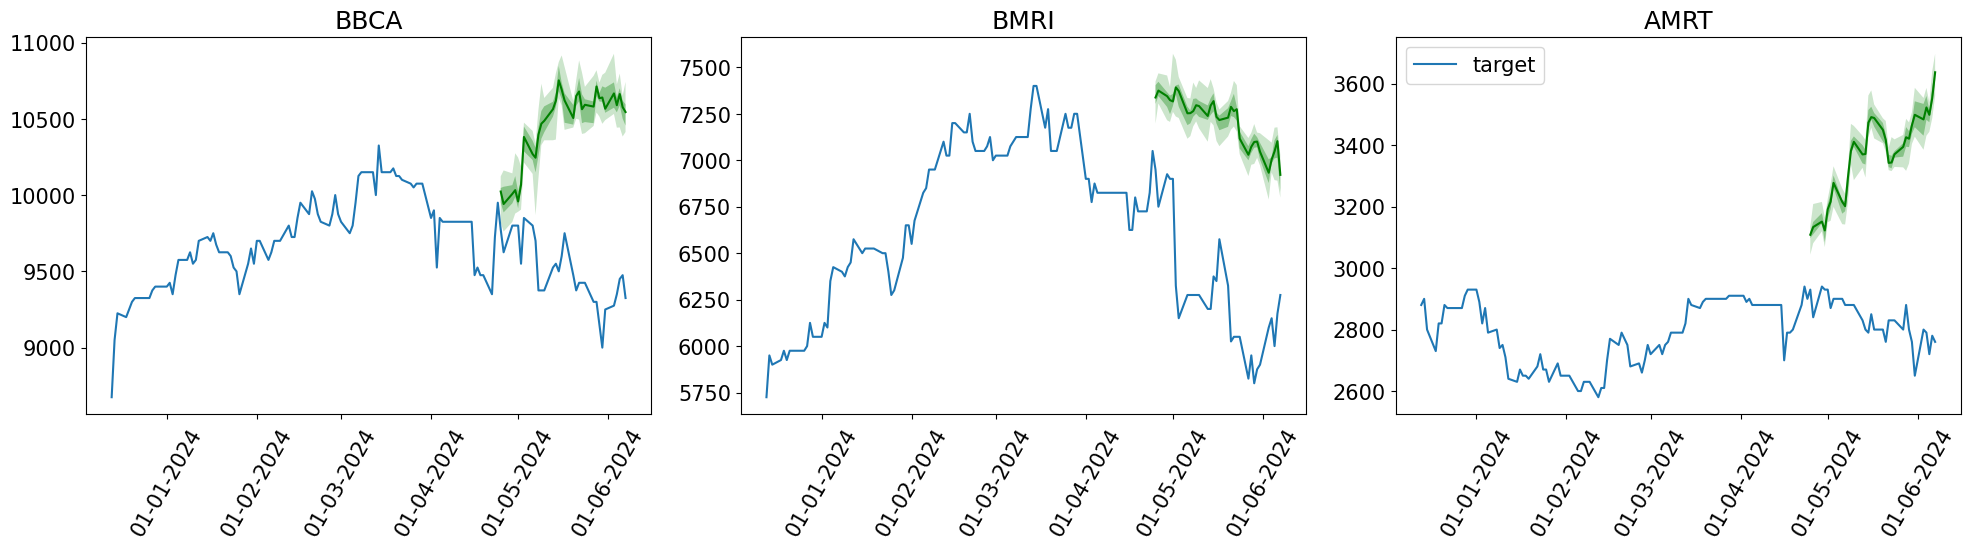

In [68]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_3, tss_fine_tuning_len_1024_lr_1e_3)

### ***Learning Rate 1e-4***

### Get predictions with the default context length ***(32)***

In [69]:
forecasts_fine_tuning_len_32_lr_1e_4, tss_fine_tuning_len_32_lr_1e_4, agg_metrics = lag_llama_fine_tuning(32, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.00365 (best 7.00365), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_394\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.45741 (best 6.45741), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_394\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.23516 (best 6.23516), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_394\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 6.16736 (best 6.16736), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_394\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 6.15244 (best 6.15244), saving model to

In [70]:
fine_tuning_len_32_lr_1e_4 = print_crps_fine_tuning(32, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.0001 CRPS: 0.0863


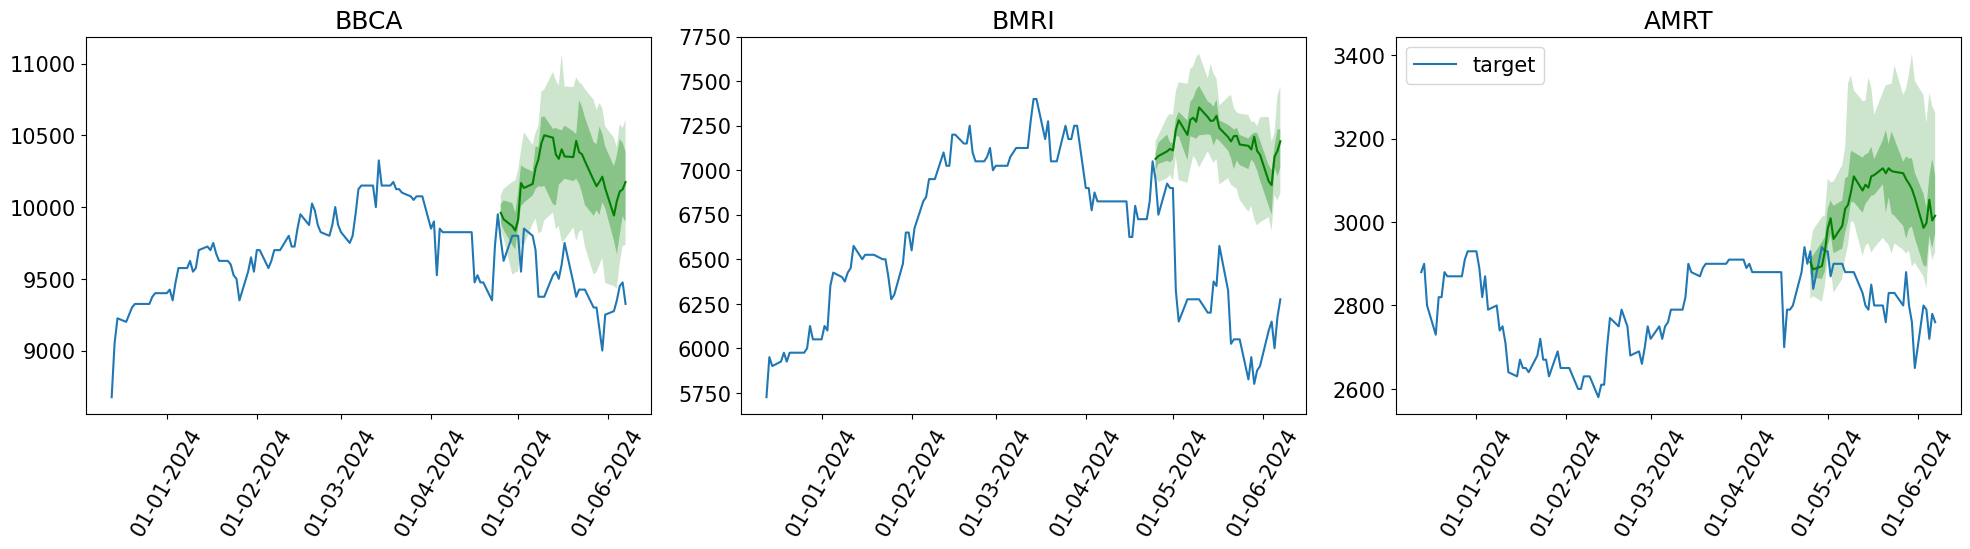

In [71]:
plotting(forecasts_fine_tuning_len_32_lr_1e_4, tss_fine_tuning_len_32_lr_1e_4)

### Get predictions with the default context length ***(64)***

In [72]:
forecasts_fine_tuning_len_64_lr_1e_4, tss_fine_tuning_len_64_lr_1e_4, agg_metrics = lag_llama_fine_tuning(64, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.11211 (best 7.11211), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_395\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.32243 (best 6.32243), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_395\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.22684 (best 6.22684), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_395\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 6.20554 (best 6.20554), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_395\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 6.13148 (best 6.13148), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [73]:
fine_tuning_len_64_lr_1e_4 = print_crps_fine_tuning(64, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.0001 CRPS: 0.0645


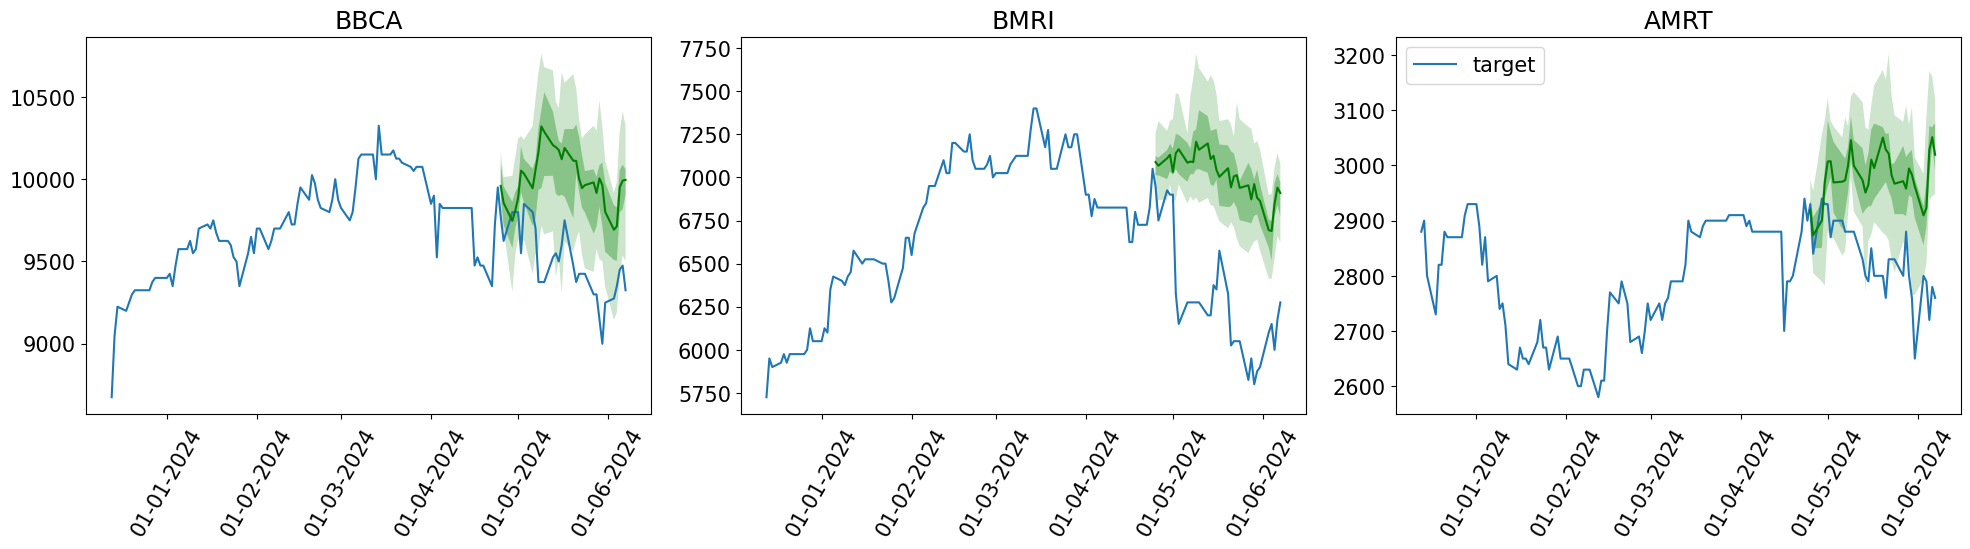

In [74]:
plotting(forecasts_fine_tuning_len_64_lr_1e_4, tss_fine_tuning_len_64_lr_1e_4)

### Get predictions with the default context length ***(128)***

In [75]:
forecasts_fine_tuning_len_128_lr_1e_4, tss_fine_tuning_len_128_lr_1e_4, agg_metrics = lag_llama_fine_tuning(128, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.18585 (best 7.18585), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_397\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.25162 (best 6.25162), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_397\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.24292 (best 6.24292), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_397\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.12565 (best 6.12565), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_397\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.11548 (best 6.11548), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_397\\checkpoints\\epoch=4-step=250.ckpt' as top

In [76]:
fine_tuning_len_128_lr_1e_4 = print_crps_fine_tuning(128, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.0001 CRPS: 0.1146


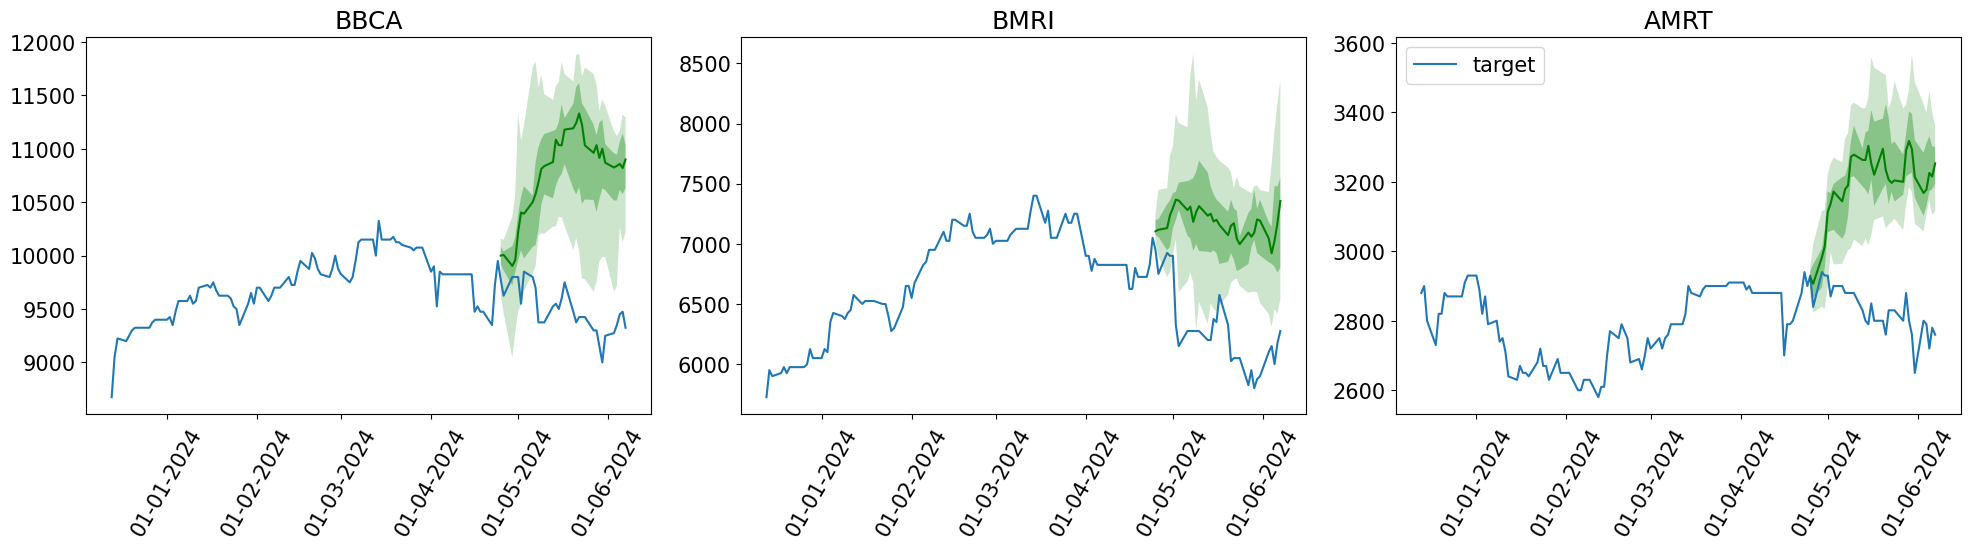

In [77]:
plotting(forecasts_fine_tuning_len_128_lr_1e_4, tss_fine_tuning_len_128_lr_1e_4)

### Get predictions with the default context length ***(256)***

In [78]:
forecasts_fine_tuning_len_256_lr_1e_4, tss_fine_tuning_len_256_lr_1e_4, agg_metrics = lag_llama_fine_tuning(256, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.17945 (best 7.17945), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_398\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.32501 (best 6.32501), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_398\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.26354 (best 6.26354), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_398\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.21041 (best 6.21041), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_398\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.17375 (best 6.17375), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_398\\checkpoints\\epoch=4-step=250.ckpt' as top

In [79]:
fine_tuning_len_256_lr_1e_4 = print_crps_fine_tuning(256, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.0001 CRPS: 0.0649


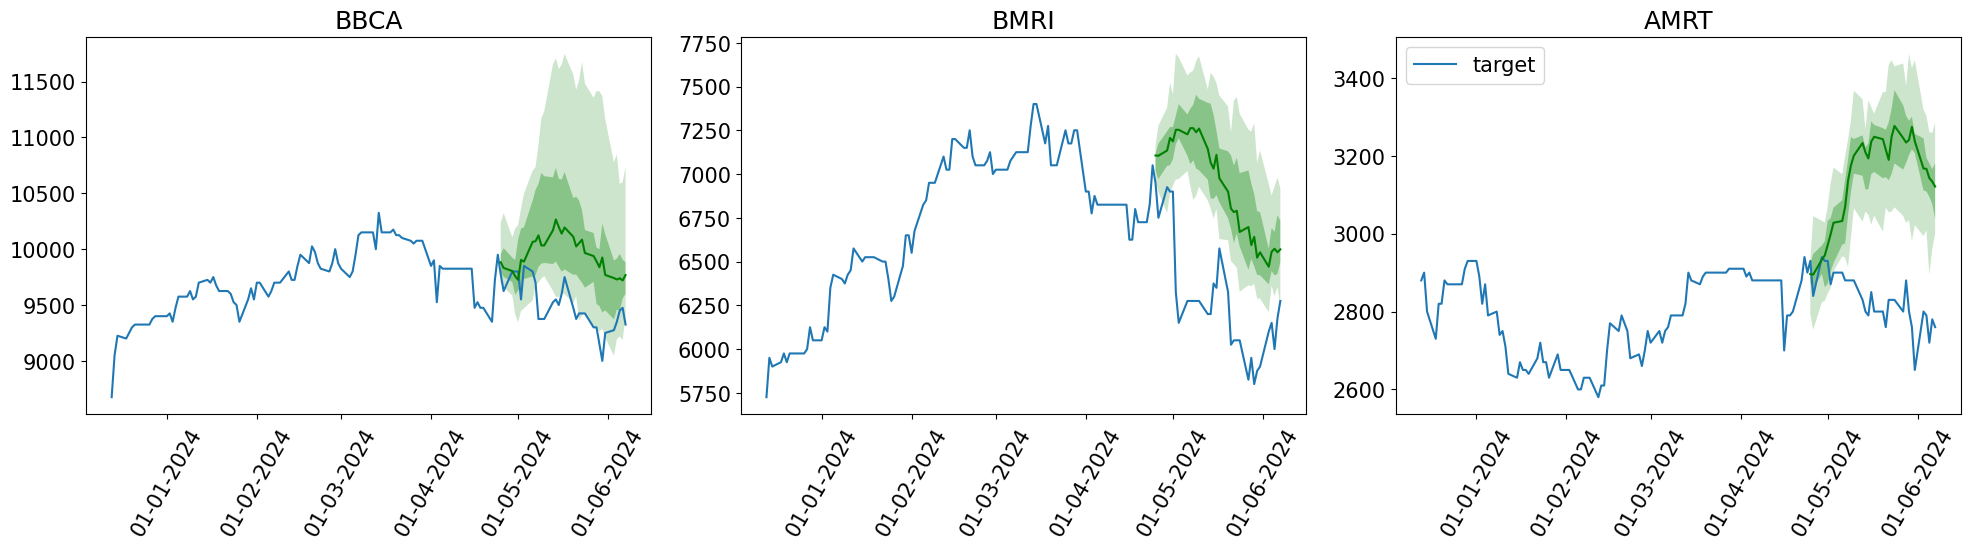

In [80]:
plotting(forecasts_fine_tuning_len_256_lr_1e_4, tss_fine_tuning_len_256_lr_1e_4)

### Get predictions with the default context length ***(512)***

In [81]:
forecasts_fine_tuning_len_512_lr_1e_4, tss_fine_tuning_len_512_lr_1e_4, agg_metrics = lag_llama_fine_tuning(512, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.79287 (best 6.79287), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_399\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.25755 (best 6.25755), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_399\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.25216 (best 6.25216), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_399\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.18505 (best 6.18505), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_399\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.18016 (best 6.18016), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_399\\checkpoints\\epoch=4-step=250.ckpt' as top

In [82]:
fine_tuning_len_512_lr_1e_4 = print_crps_fine_tuning(512, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.0001 CRPS: 0.0349


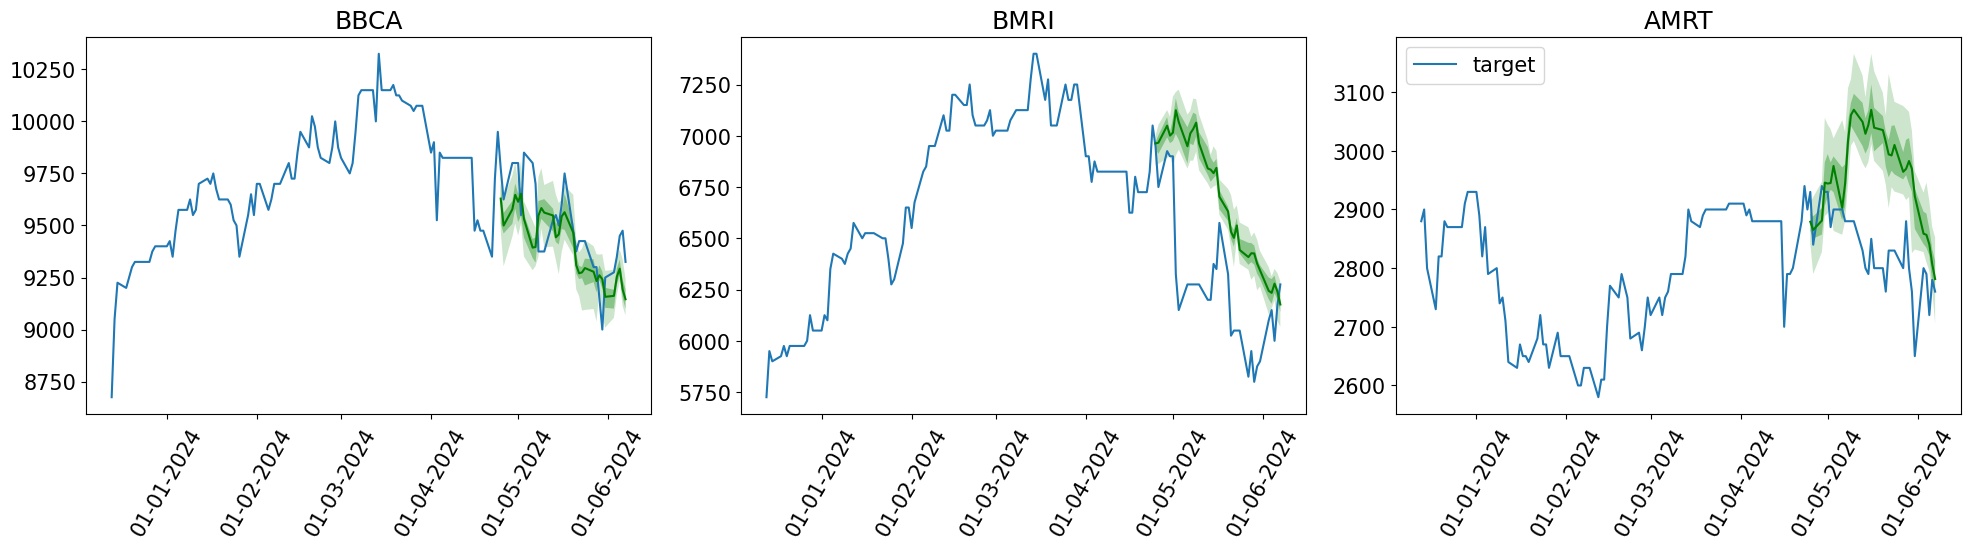

In [83]:
plotting(forecasts_fine_tuning_len_512_lr_1e_4, tss_fine_tuning_len_512_lr_1e_4)

### Get predictions with the default context length ***(1024)***

In [84]:
forecasts_fine_tuning_len_1024_lr_1e_4, tss_fine_tuning_len_1024_lr_1e_4, agg_metrics = lag_llama_fine_tuning(1024, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.93819 (best 6.93819), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_400\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.27627 (best 6.27627), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_400\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 6.19507 (best 6.19507), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_400\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.15782 (best 6.15782), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_400\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 6.11351 (best 6.11351), saving model to

In [85]:
fine_tuning_len_1024_lr_1e_4 = print_crps_fine_tuning(1024, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.0001 CRPS: 0.0362


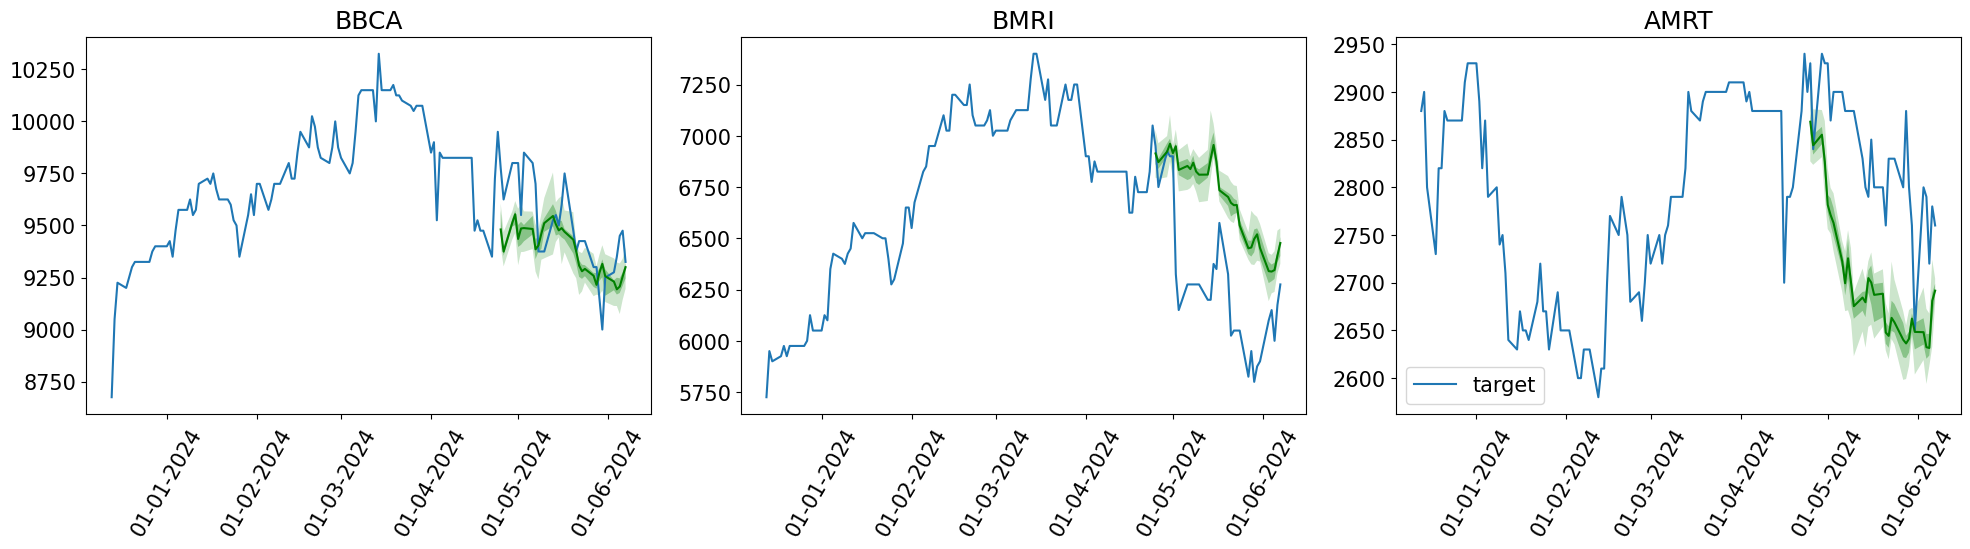

In [86]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_4, tss_fine_tuning_len_1024_lr_1e_4)

### ***Learning Rate 5e-3***

### Get predictions with the default context length ***(32)***

In [87]:
forecasts_fine_tuning_len_32_lr_5e_3, tss_fine_tuning_len_32_lr_5e_3, agg_metrics = lag_llama_fine_tuning(32, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.04586 (best 10.04586), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_406\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.15006 (best 9.15006), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_406\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.95648 (best 8.95648), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_406\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.77300 (best 8.77300), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_406\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.20813 (best 8.20813), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_406\\checkpoints\\epoch=4-step=250.ckpt' as t

In [88]:
fine_tuning_len_32_lr_5e_3 = print_crps_fine_tuning(32, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.005 CRPS: 0.0250


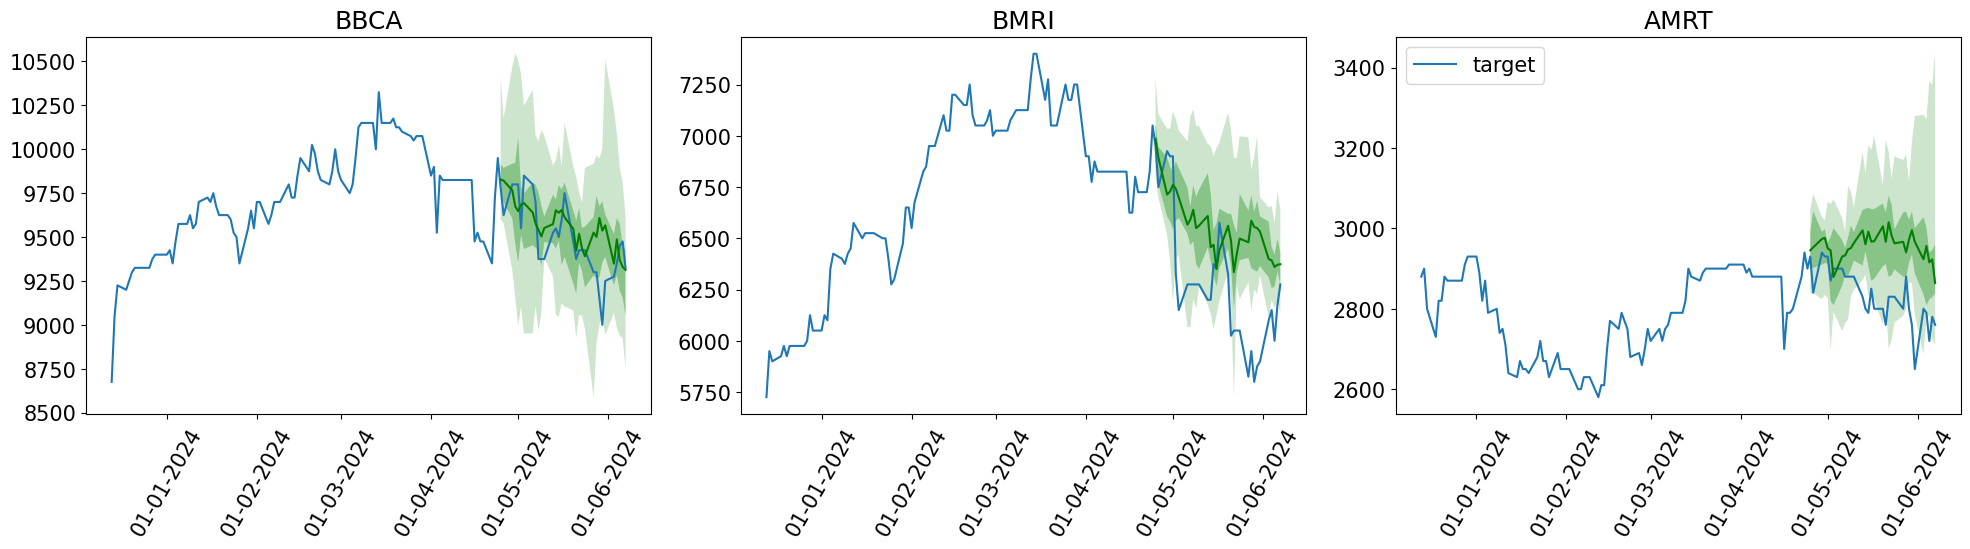

In [89]:
plotting(forecasts_fine_tuning_len_32_lr_5e_3, tss_fine_tuning_len_32_lr_5e_3)

### Get predictions with the default context length ***(64)***

In [90]:
forecasts_fine_tuning_len_64_lr_5e_3, tss_fine_tuning_len_64_lr_5e_3, agg_metrics = lag_llama_fine_tuning(64, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.99509 (best 9.99509), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_408\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.98847 (best 8.98847), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_408\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 8.78365 (best 8.78365), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_408\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.17231 (best 8.17231), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_408\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 8.06499 (best 8.06499), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [91]:
fine_tuning_len_64_lr_5e_3 = print_crps_fine_tuning(64, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.005 CRPS: 0.1221


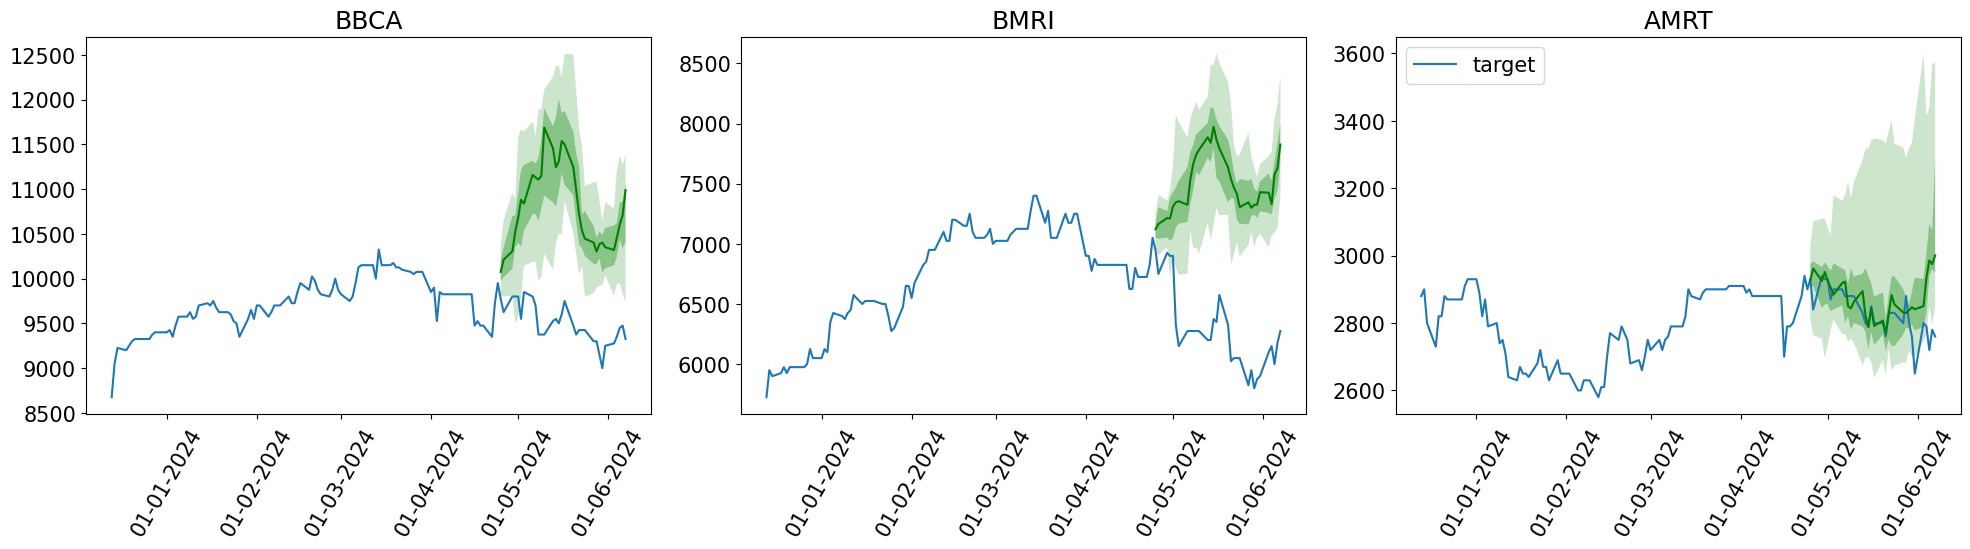

In [92]:
plotting(forecasts_fine_tuning_len_64_lr_5e_3, tss_fine_tuning_len_64_lr_5e_3)

### Get predictions with the default context length ***(128)***

In [93]:
forecasts_fine_tuning_len_128_lr_5e_3, tss_fine_tuning_len_128_lr_5e_3, agg_metrics = lag_llama_fine_tuning(128, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.83291 (best 9.83291), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_409\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.98299 (best 8.98299), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_409\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 8.83871 (best 8.83871), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_409\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 8.27082 (best 8.27082), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_409\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 7.88992 (best 7.88992), saving model to

In [94]:
fine_tuning_len_128_lr_5e_3 = print_crps_fine_tuning(128, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.005 CRPS: 0.0295


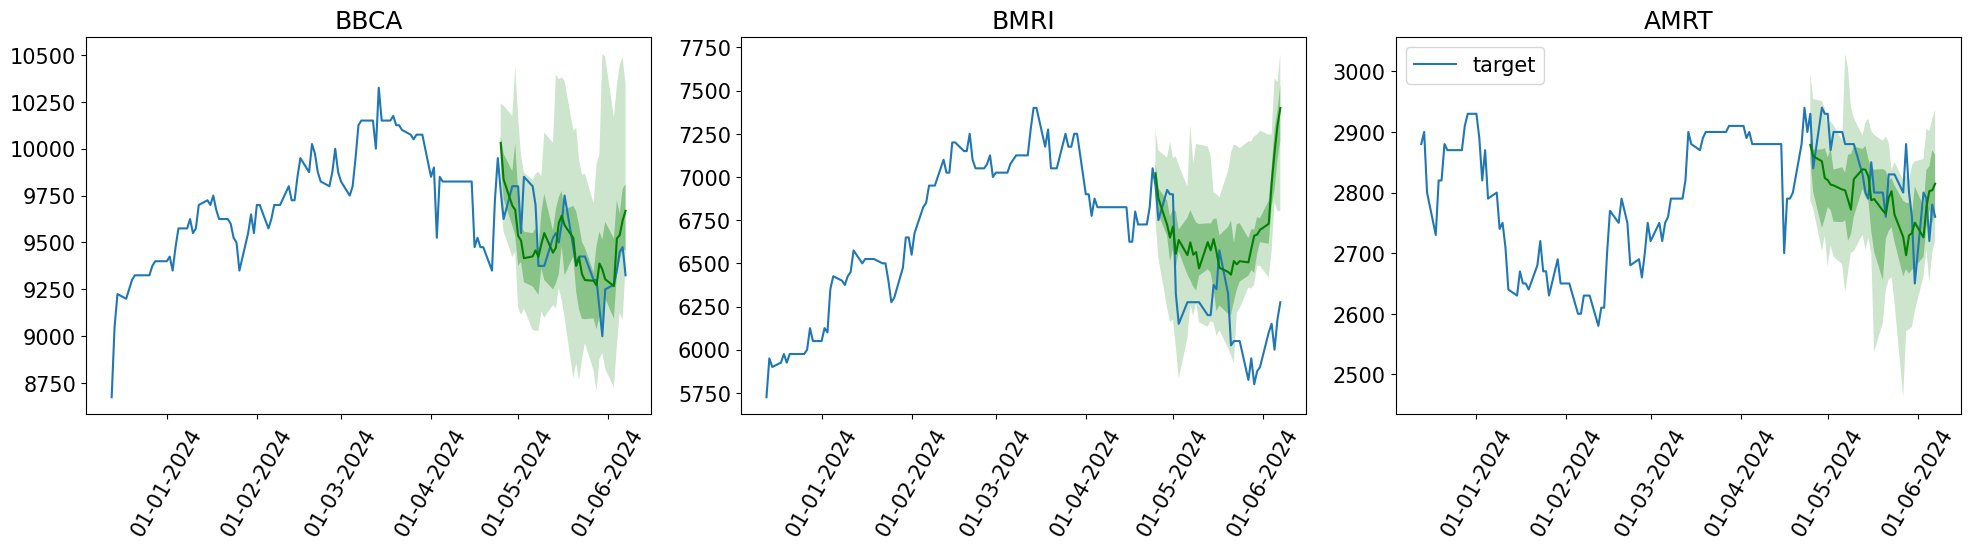

In [95]:
plotting(forecasts_fine_tuning_len_128_lr_5e_3, tss_fine_tuning_len_128_lr_5e_3)

### Get predictions with the default context length ***(256)***

In [96]:
forecasts_fine_tuning_len_256_lr_5e_3, tss_fine_tuning_len_256_lr_5e_3, agg_metrics = lag_llama_fine_tuning(256, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.79778 (best 9.79778), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_410\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.76833 (best 8.76833), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_410\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 8.69145 (best 8.69145), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_410\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.26568 (best 8.26568), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_410\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 8.01585 (best 8.01585), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [97]:
fine_tuning_len_256_lr_5e_3 = print_crps_fine_tuning(256, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.005 CRPS: 0.1313


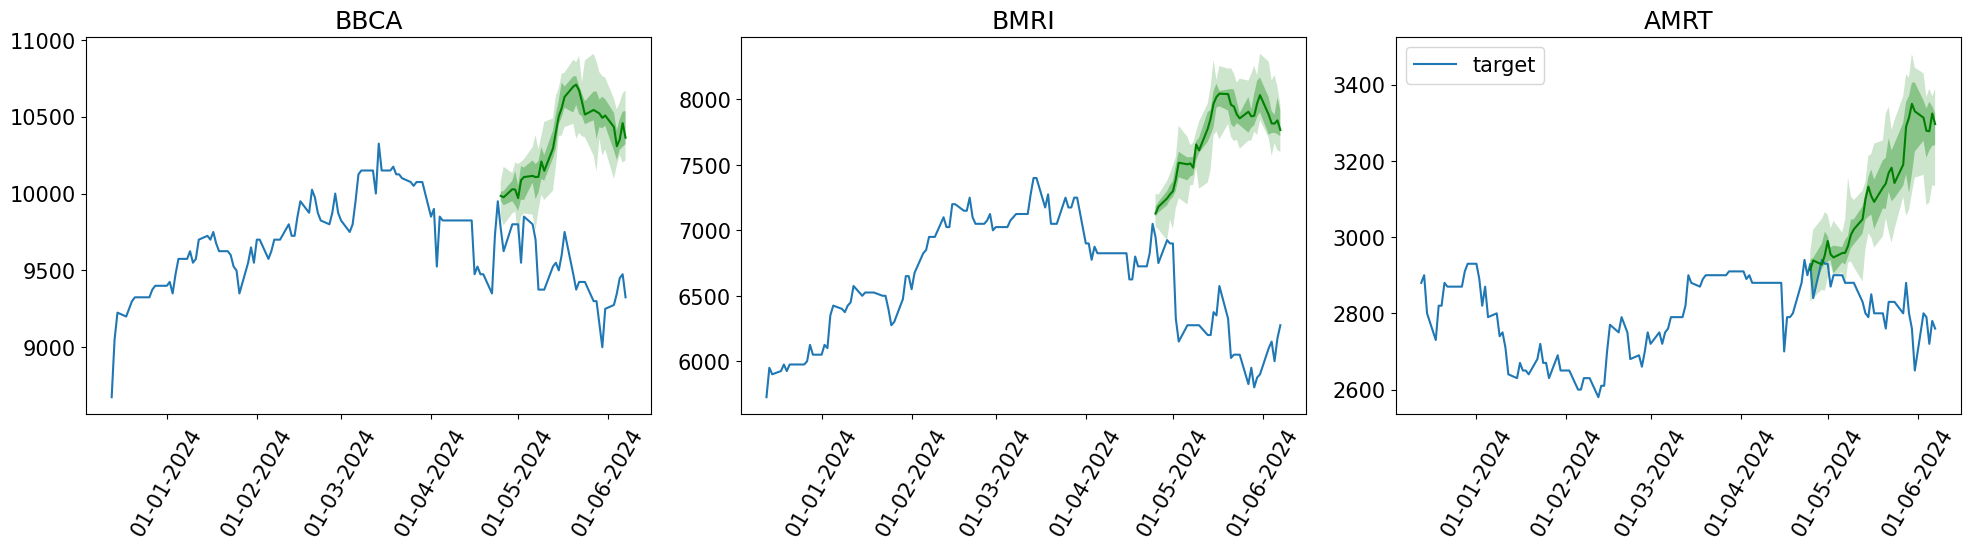

In [98]:
plotting(forecasts_fine_tuning_len_256_lr_5e_3, tss_fine_tuning_len_256_lr_5e_3)

### Get predictions with the default context length ***(512)***

In [99]:
forecasts_fine_tuning_len_512_lr_5e_3, tss_fine_tuning_len_512_lr_5e_3, agg_metrics = lag_llama_fine_tuning(512, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.80578 (best 9.80578), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_411\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.68848 (best 8.68848), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_411\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.48509 (best 8.48509), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_411\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.42393 (best 8.42393), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_411\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.17527 (best 8.17527), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_411\\checkpoints\\epoch=4-step=250.ckpt' as top

In [100]:
fine_tuning_len_512_lr_5e_3 = print_crps_fine_tuning(512, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.005 CRPS: 0.1361


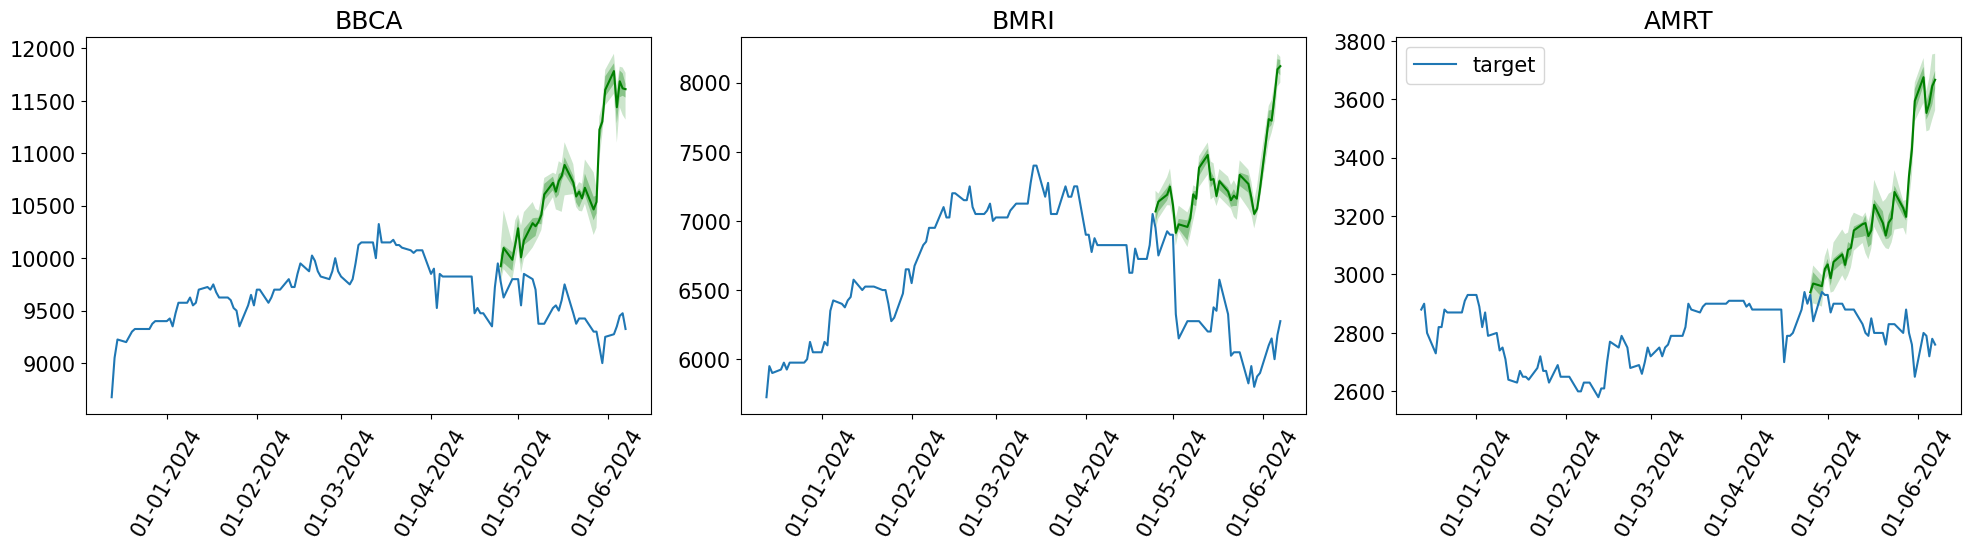

In [101]:
plotting(forecasts_fine_tuning_len_512_lr_5e_3, tss_fine_tuning_len_512_lr_5e_3)

### Get predictions with the default context length ***(1024)***

In [102]:
forecasts_fine_tuning_len_1024_lr_5e_3, tss_fine_tuning_len_1024_lr_5e_3, agg_metrics = lag_llama_fine_tuning(1024, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.29130 (best 9.29130), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_412\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.64526 (best 8.64526), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_412\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 8.58306 (best 8.58306), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_412\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.43882 (best 8.43882), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_412\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 8.32370 (best 8.32370), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [103]:
fine_tuning_len_1024_lr_5e_3 = print_crps_fine_tuning(1024, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.005 CRPS: 0.0273


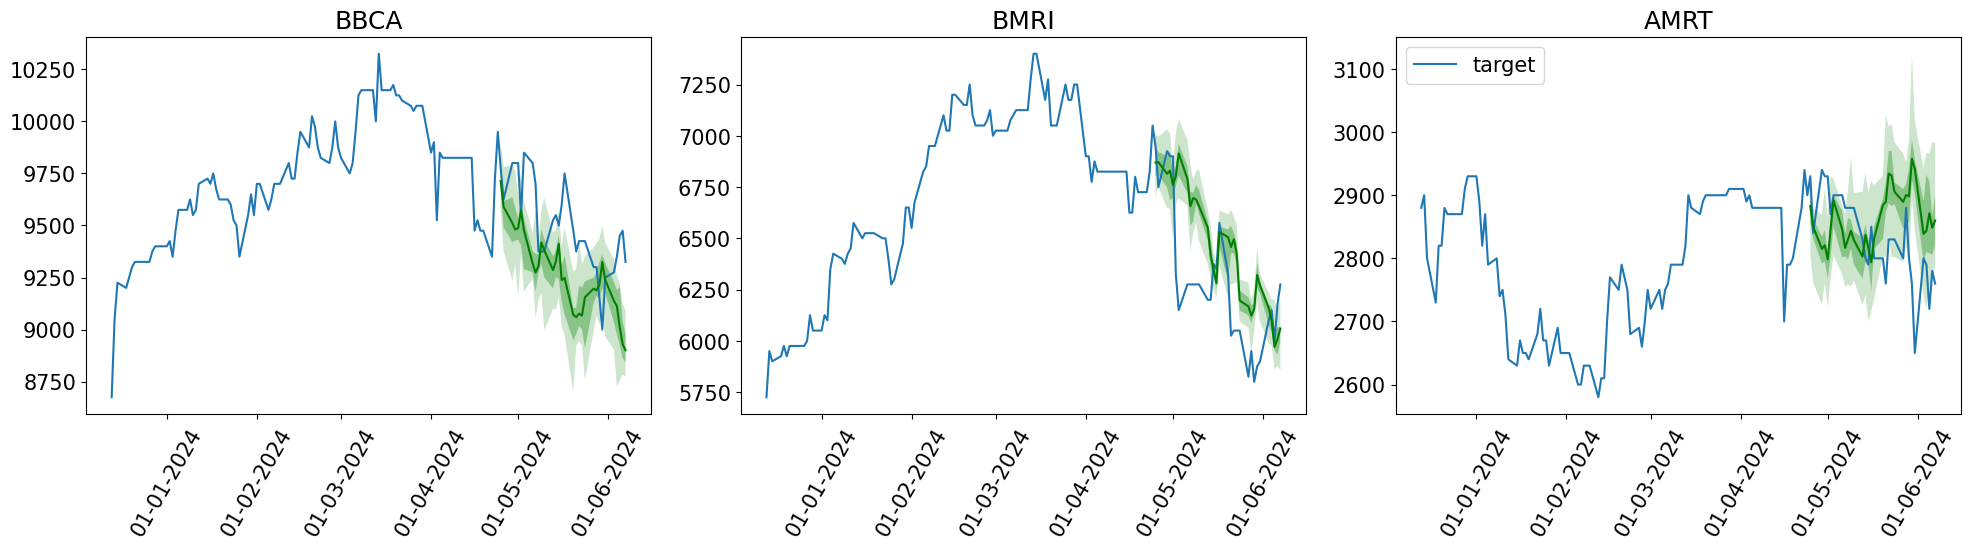

In [104]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_3, tss_fine_tuning_len_1024_lr_5e_3)

### ***Learning Rate 5e-4***

### Get predictions with the default context length ***(32)***

In [105]:
forecasts_fine_tuning_len_32_lr_5e_4, tss_fine_tuning_len_32_lr_5e_4, agg_metrics = lag_llama_fine_tuning(32, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.58775 (best 8.58775), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_418\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.46195 (best 7.46195), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_418\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 7.20517 (best 7.20517), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_418\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 7.19780 (best 7.19780), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_418\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 6.73997 (best 6.73997), saving model to

In [106]:
fine_tuning_len_32_lr_5e_4 = print_crps_fine_tuning(32, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.0005 CRPS: 0.0318


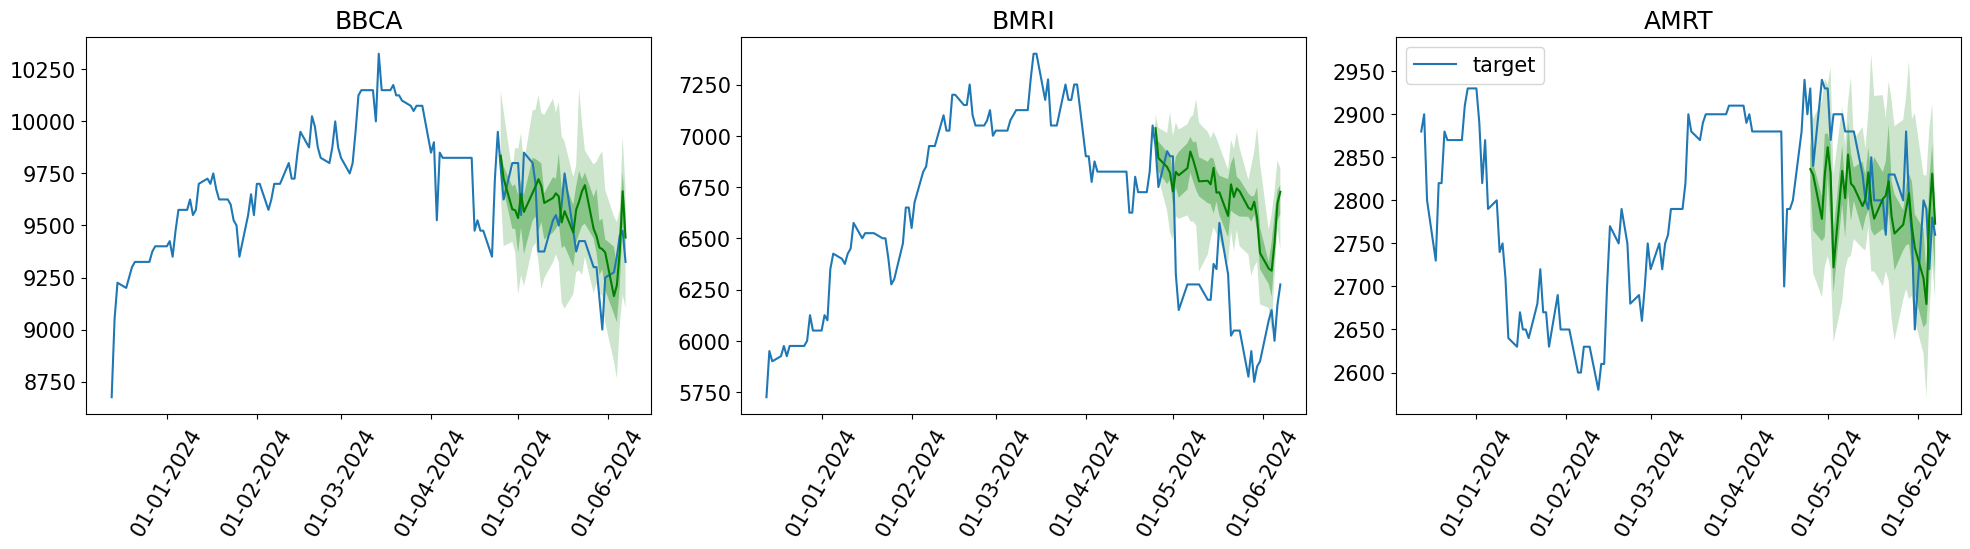

In [107]:
plotting(forecasts_fine_tuning_len_32_lr_5e_4, tss_fine_tuning_len_32_lr_5e_4)

### Get predictions with the default context length ***(64)***

In [108]:
forecasts_fine_tuning_len_64_lr_5e_4, tss_fine_tuning_len_64_lr_5e_4, agg_metrics = lag_llama_fine_tuning(64, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.73289 (best 8.73289), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_420\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.26922 (best 7.26922), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_420\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.90526 (best 6.90526), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_420\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 6.69240 (best 6.69240), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_420\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' was not in top 1
Epoch 7, global step 400: 'tra

In [109]:
fine_tuning_len_64_lr_5e_4 = print_crps_fine_tuning(64, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.0005 CRPS: 0.1218


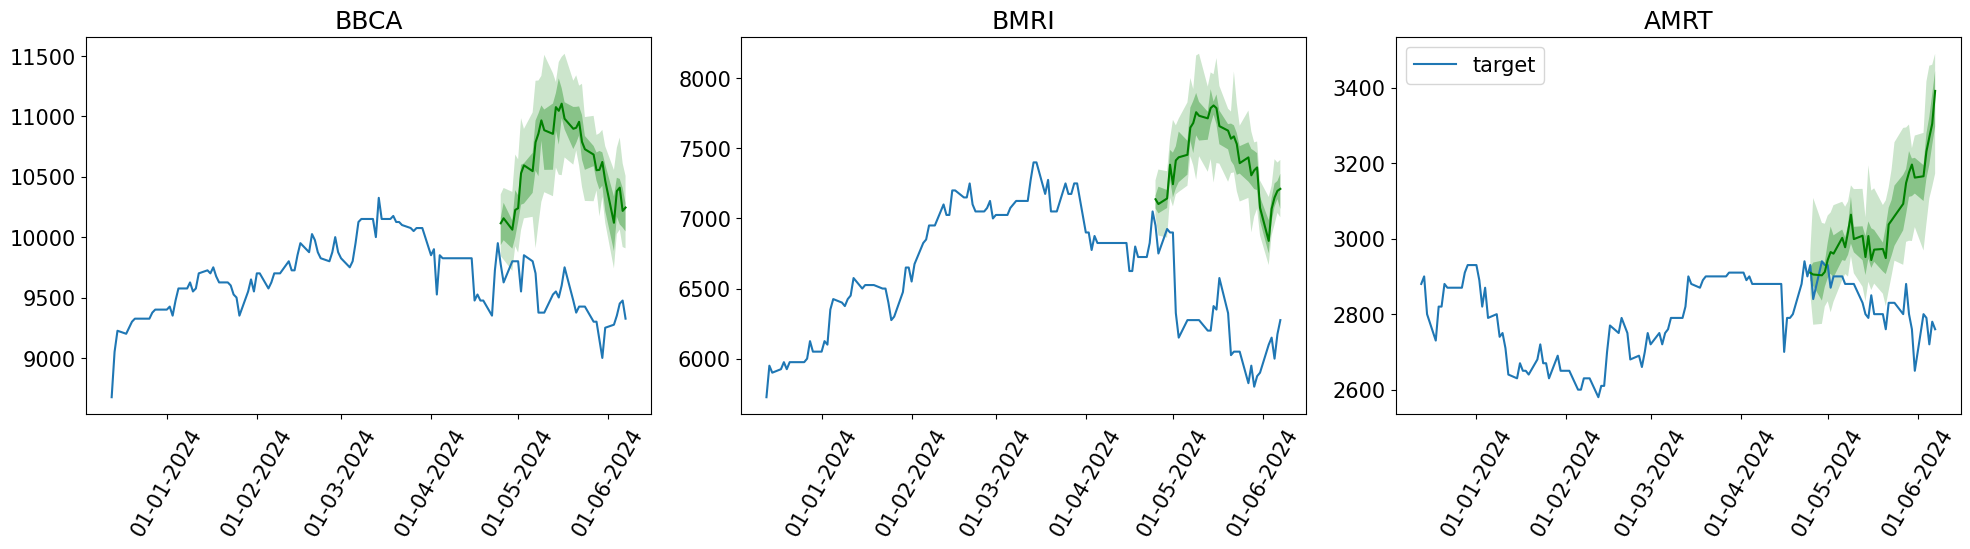

In [110]:
plotting(forecasts_fine_tuning_len_64_lr_5e_4, tss_fine_tuning_len_64_lr_5e_4)

### Get predictions with the default context length ***(128)***

In [111]:
forecasts_fine_tuning_len_128_lr_5e_4, tss_fine_tuning_len_128_lr_5e_4, agg_metrics = lag_llama_fine_tuning(128, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.13876 (best 9.13876), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_421\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.40452 (best 7.40452), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_421\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.95114 (best 6.95114), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_421\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.63195 (best 6.63195), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_421\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 6.54848 (best 6.54848), saving model to

In [112]:
fine_tuning_len_128_lr_5e_4 = print_crps_fine_tuning(128, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.0005 CRPS: 0.0464


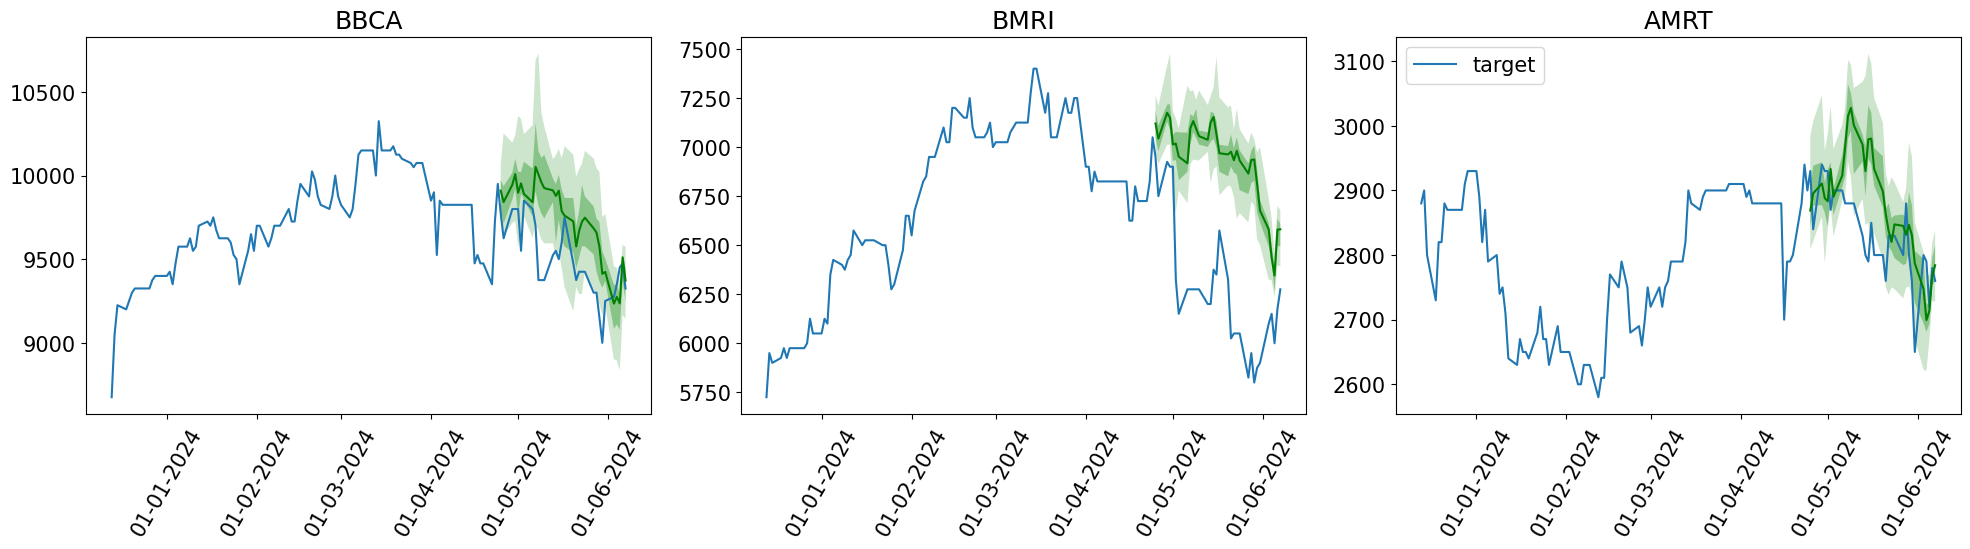

In [113]:
plotting(forecasts_fine_tuning_len_128_lr_5e_4, tss_fine_tuning_len_128_lr_5e_4)

### Get predictions with the default context length ***(256)***

In [114]:
forecasts_fine_tuning_len_256_lr_5e_4, tss_fine_tuning_len_256_lr_5e_4, agg_metrics = lag_llama_fine_tuning(256, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.09046 (best 9.09046), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_422\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.61749 (best 7.61749), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_422\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.52048 (best 7.52048), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_422\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.91099 (best 6.91099), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_422\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 6.62132 (best 6.62132), saving model to

In [115]:
fine_tuning_len_256_lr_5e_4 = print_crps_fine_tuning(256, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.0005 CRPS: 0.1117


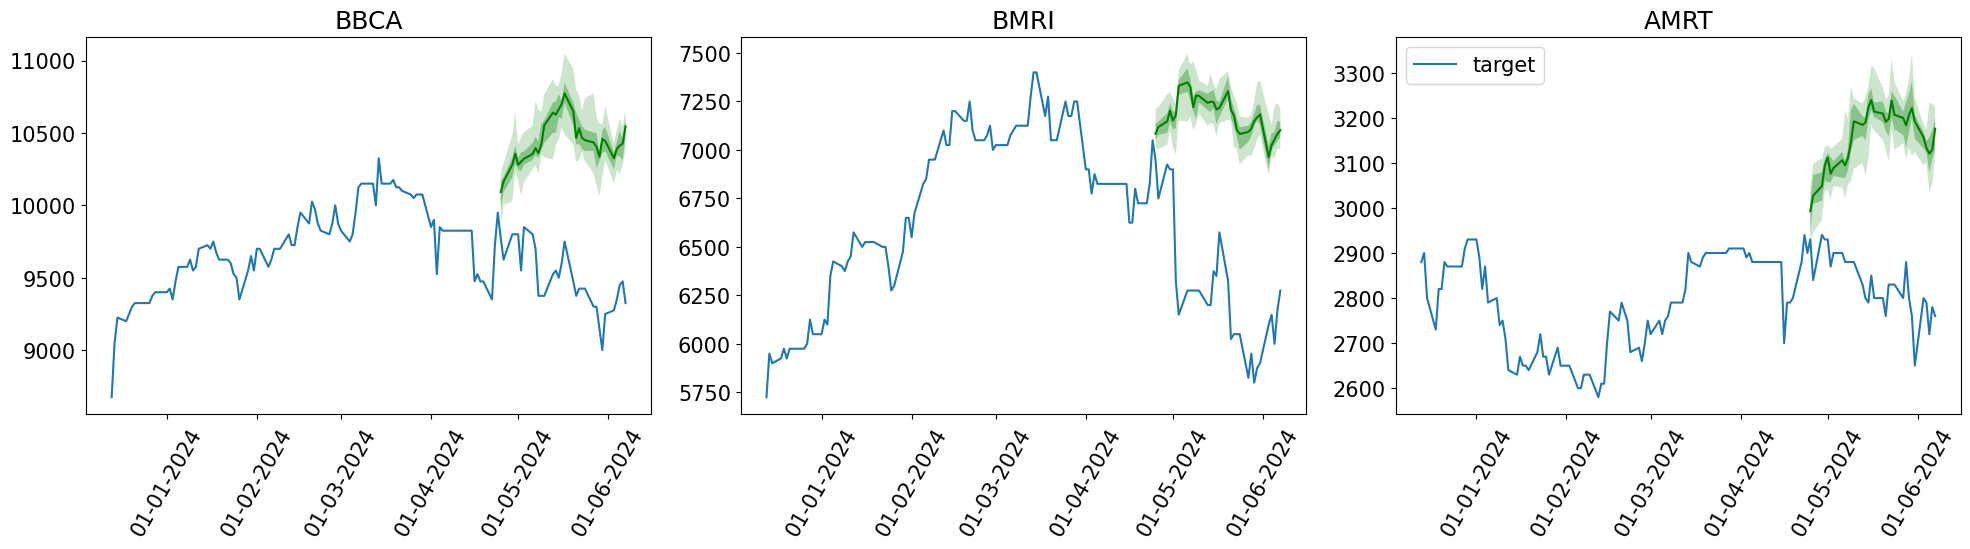

In [116]:
plotting(forecasts_fine_tuning_len_256_lr_5e_4, tss_fine_tuning_len_256_lr_5e_4)

### Get predictions with the default context length ***(512)***

In [131]:
forecasts_fine_tuning_len_512_lr_5e_4, tss_fine_tuning_len_512_lr_5e_4, agg_metrics = lag_llama_fine_tuning(512, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.53630 (best 8.53630), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_430\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.45494 (best 7.45494), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_430\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.17111 (best 7.17111), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_430\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.65682 (best 6.65682), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_430\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.59915 (best 6.59915), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_430\\checkpoints\\epoch=4-step=250.ckpt' as top

In [132]:
fine_tuning_len_512_lr_5e_4 = print_crps_fine_tuning(512, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.0005 CRPS: 0.0666


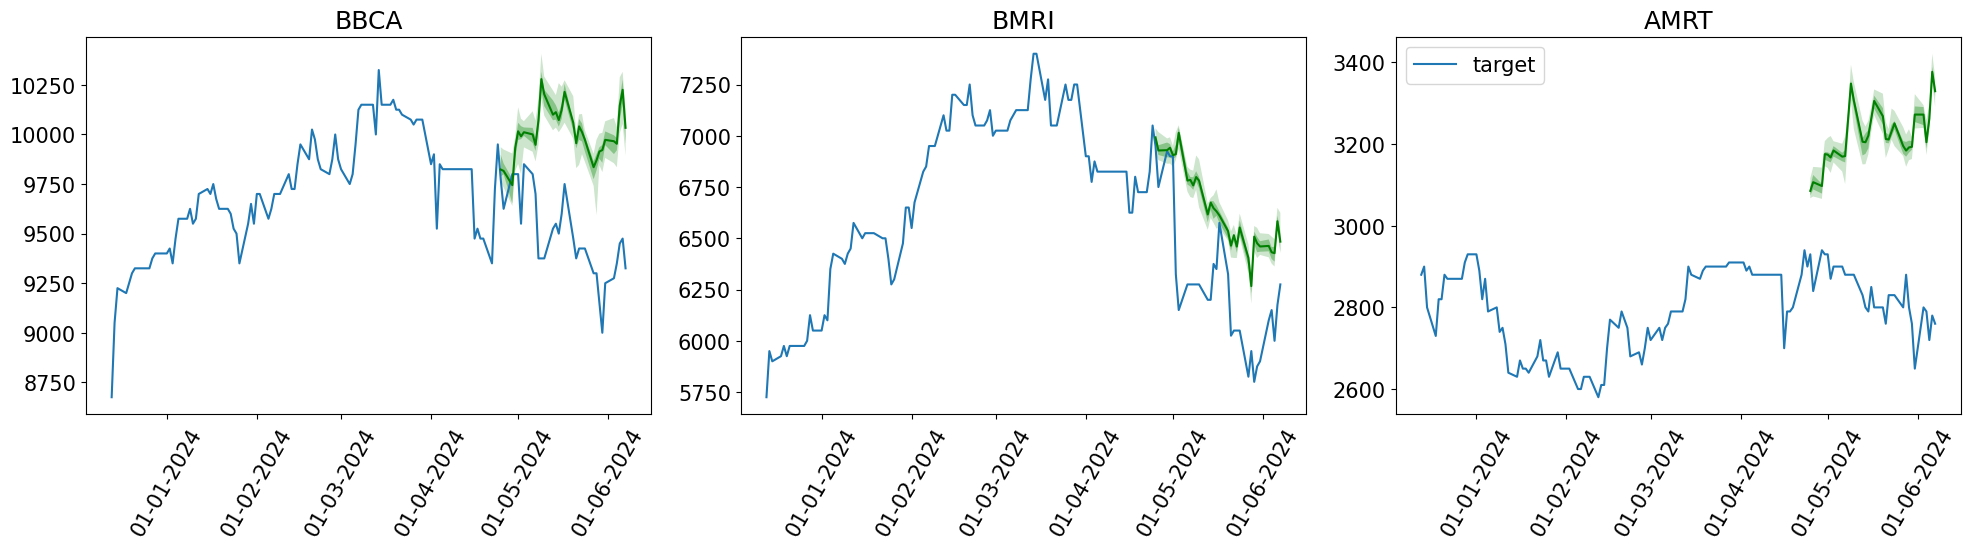

In [133]:
plotting(forecasts_fine_tuning_len_512_lr_5e_4, tss_fine_tuning_len_512_lr_5e_4)

### Get predictions with the default context length ***(1024)***

In [134]:
forecasts_fine_tuning_len_1024_lr_5e_4, tss_fine_tuning_len_1024_lr_5e_4, agg_metrics = lag_llama_fine_tuning(1024, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.44991 (best 8.44991), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_432\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.12752 (best 7.12752), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_432\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.82011 (best 6.82011), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_432\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.66701 (best 6.66701), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_432\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.61707 (best 6.61707), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [135]:
fine_tuning_len_1024_lr_5e_4 = print_crps_fine_tuning(1024, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.0005 CRPS: 0.0378


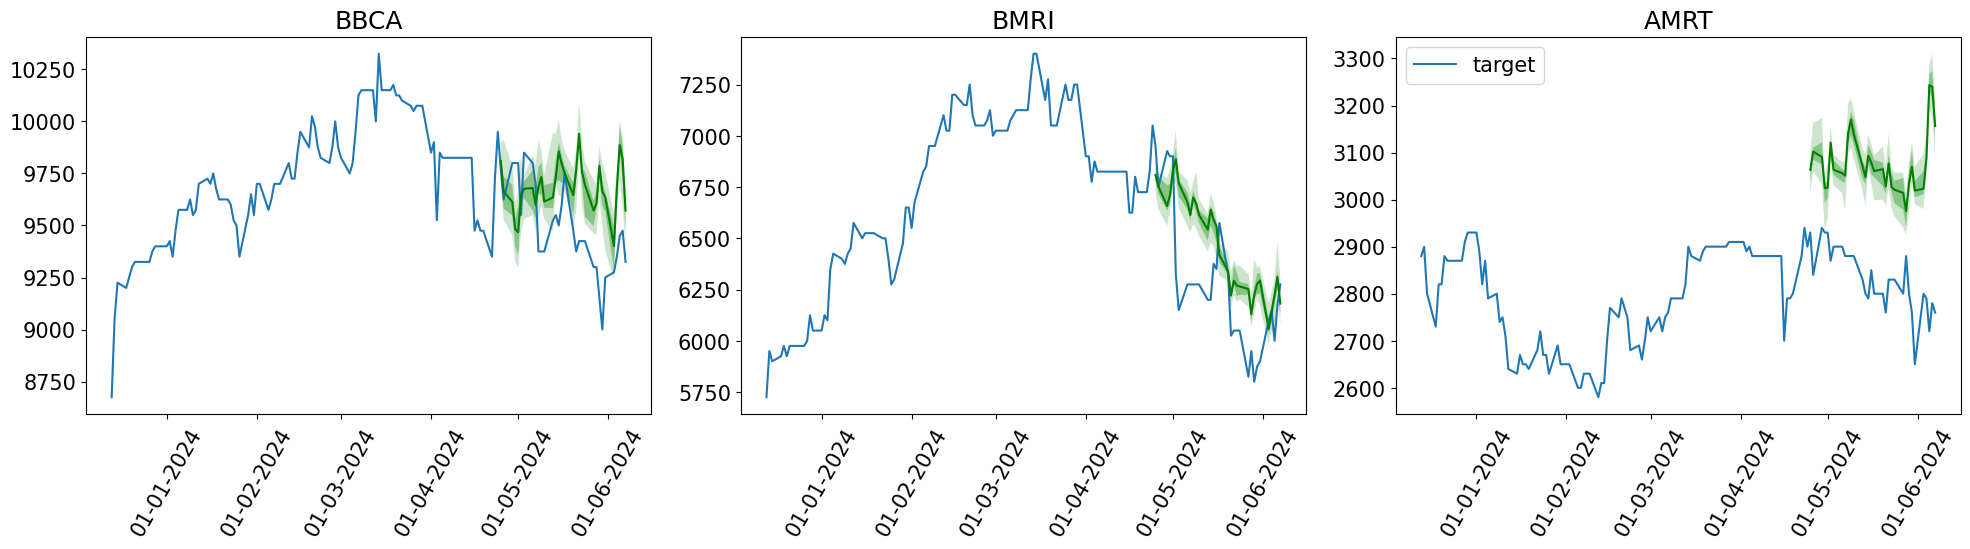

In [136]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_4, tss_fine_tuning_len_1024_lr_5e_4)

### ***Learning Rate 5e-5***

### Get predictions with the default context length ***(32)***

In [19]:
forecasts_fine_tuning_len_32_lr_5e_5, tss_fine_tuning_len_32_lr_5e_5, agg_metrics = lag_llama_fine_tuning(32, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.53373 (best 6.53373), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_433\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.22003 (best 6.22003), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_433\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.07365 (best 6.07365), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_433\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 6.07181 (best 6.07181), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_433\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 6.05458 (best 6.05458), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [20]:
fine_tuning_len_32_lr_5e_5 = print_crps_fine_tuning(32, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 5e-05 CRPS: 0.0258


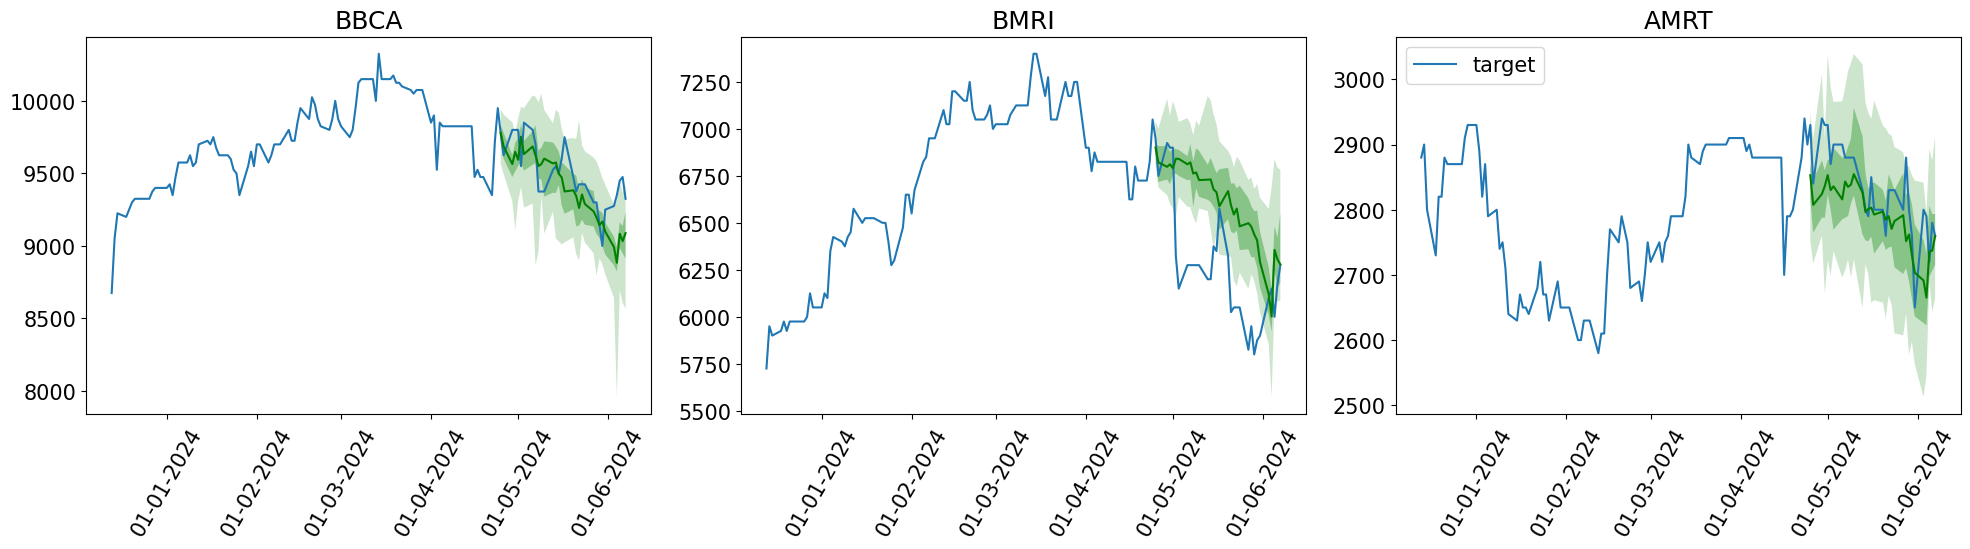

In [21]:
plotting(forecasts_fine_tuning_len_32_lr_5e_5, tss_fine_tuning_len_32_lr_5e_5)

### Get predictions with the default context length ***(64)***

In [22]:
forecasts_fine_tuning_len_64_lr_5e_5, tss_fine_tuning_len_64_lr_5e_5, agg_metrics = lag_llama_fine_tuning(64, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.56186 (best 6.56186), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_435\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.17446 (best 6.17446), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_435\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.16628 (best 6.16628), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_435\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.13437 (best 6.13437), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_435\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.08519 (best 6.08519), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_435\\checkpoints\\epoch=4-step=250.ckpt' as top

In [23]:
fine_tuning_len_64_lr_5e_5 = print_crps_fine_tuning(64, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 5e-05 CRPS: 0.0576


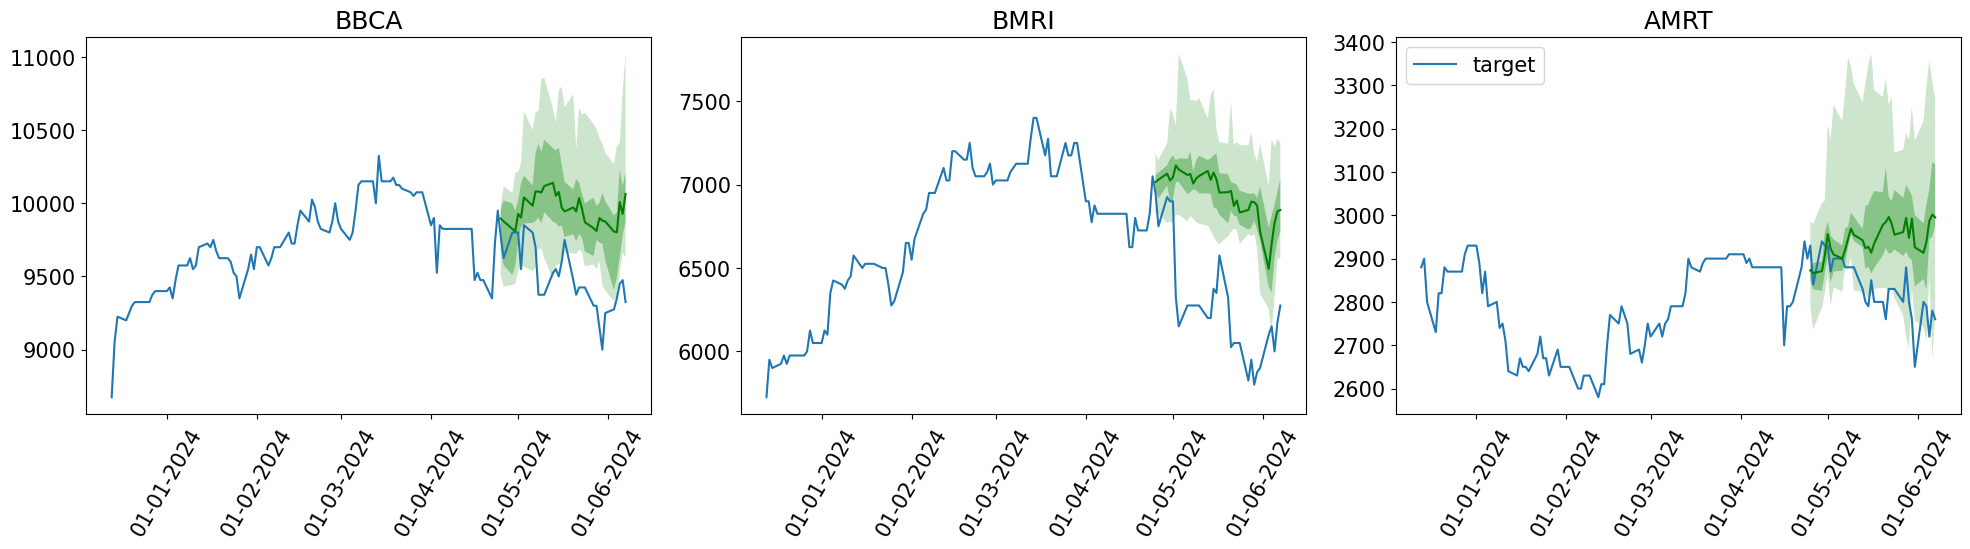

In [24]:
plotting(forecasts_fine_tuning_len_64_lr_5e_5, tss_fine_tuning_len_64_lr_5e_5)

### Get predictions with the default context length ***(128)***

In [25]:
forecasts_fine_tuning_len_128_lr_5e_5, tss_fine_tuning_len_128_lr_5e_5, agg_metrics = lag_llama_fine_tuning(128, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.55871 (best 6.55871), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_437\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.23197 (best 6.23197), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_437\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.13172 (best 6.13172), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_437\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.09780 (best 6.09780), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_437\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.08151 (best 6.08151), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_437\\checkpoints\\epoch=4-step=250.ckpt' as top

In [26]:
fine_tuning_len_128_lr_5e_5 = print_crps_fine_tuning(128, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 5e-05 CRPS: 0.0436


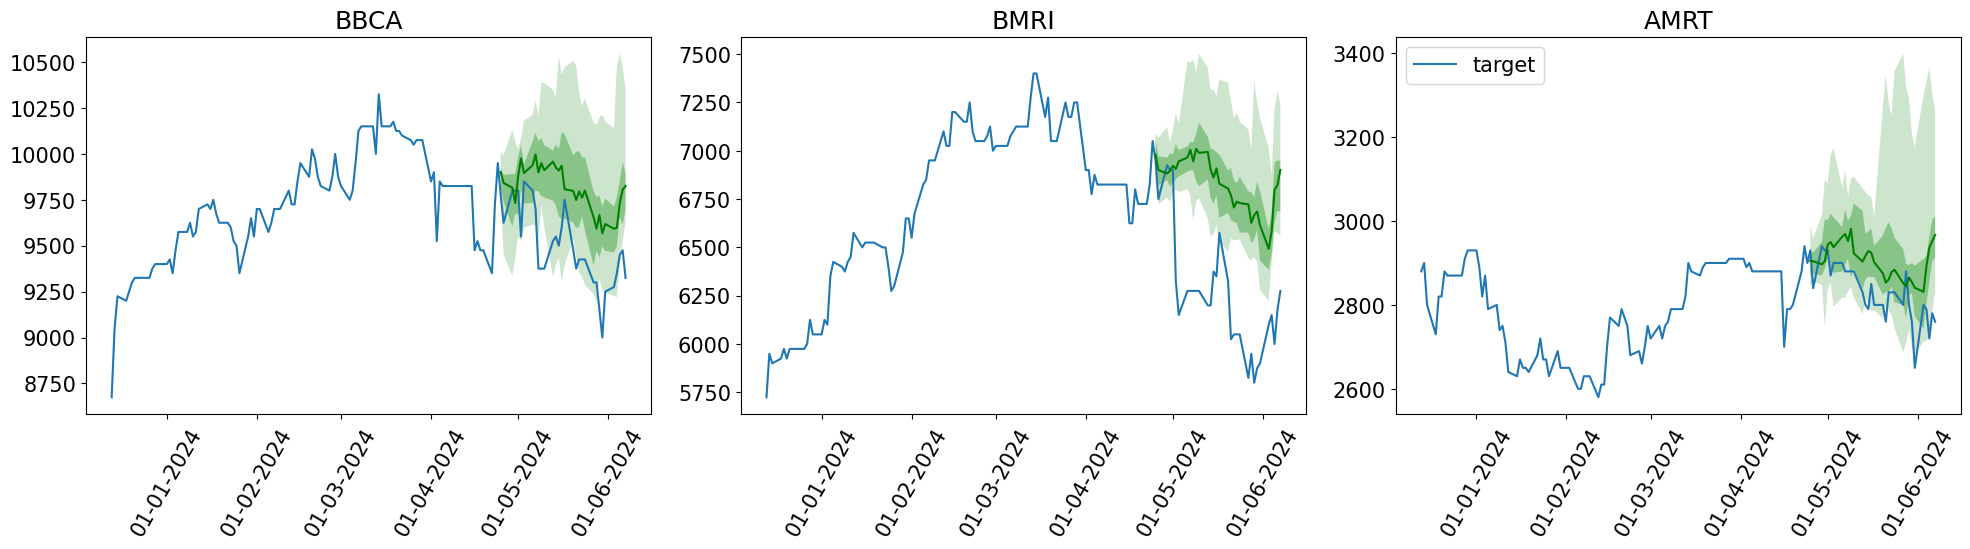

In [27]:
plotting(forecasts_fine_tuning_len_128_lr_5e_5, tss_fine_tuning_len_128_lr_5e_5)

### Get predictions with the default context length ***(256)***

In [28]:
forecasts_fine_tuning_len_256_lr_5e_5, tss_fine_tuning_len_256_lr_5e_5, agg_metrics = lag_llama_fine_tuning(256, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.58397 (best 6.58397), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_439\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.16241 (best 6.16241), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_439\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 6.07326 (best 6.07326), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_439\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 6.05354 (best 6.05354), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_439\\checkpoints\\epoch=6-step=350.ckpt' as top 1
Epoch 7, global step 400: 'tra

In [29]:
fine_tuning_len_256_lr_5e_5 = print_crps_fine_tuning(256, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 5e-05 CRPS: 0.0367


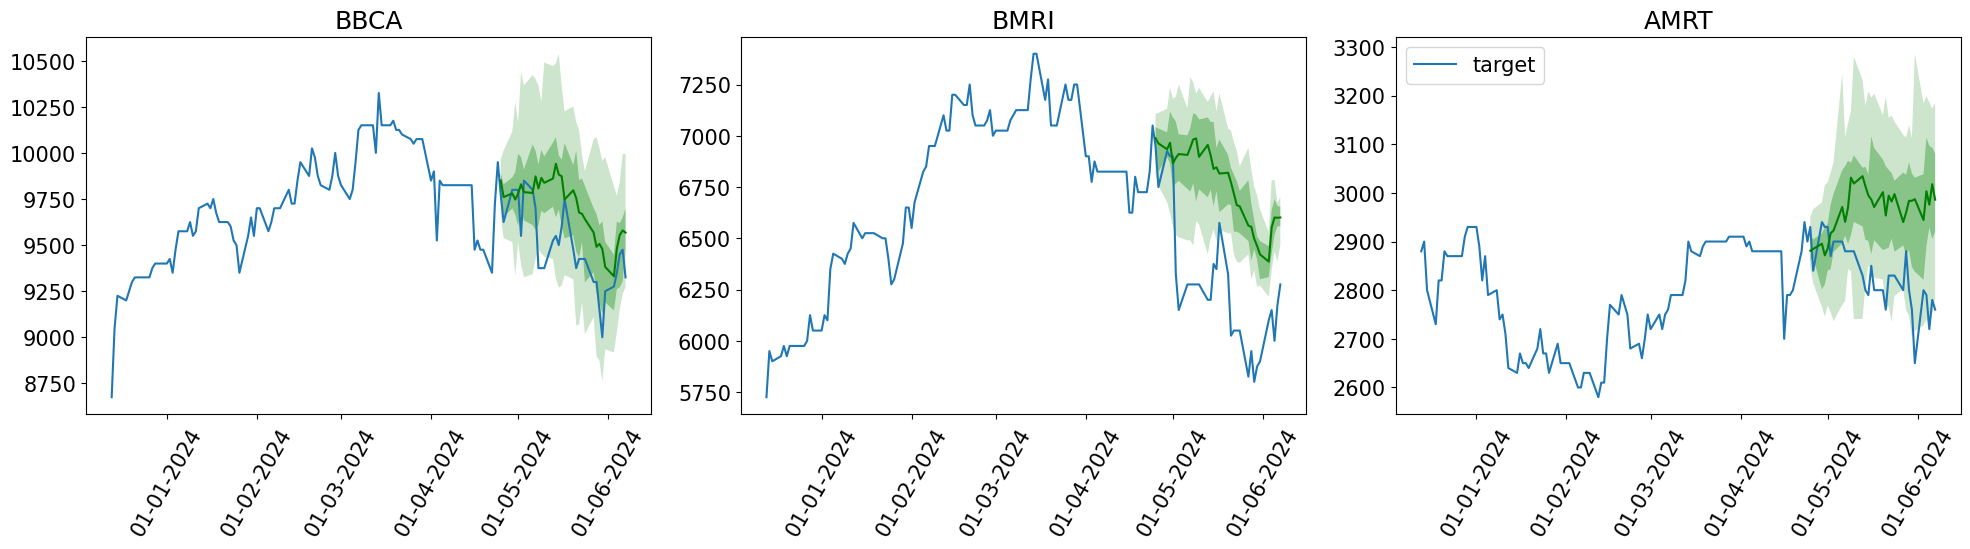

In [30]:
plotting(forecasts_fine_tuning_len_256_lr_5e_5, tss_fine_tuning_len_256_lr_5e_5)

### Get predictions with the default context length ***(512)***

In [31]:
forecasts_fine_tuning_len_512_lr_5e_5, tss_fine_tuning_len_512_lr_5e_5, agg_metrics = lag_llama_fine_tuning(512, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.64880 (best 6.64880), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_441\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.20716 (best 6.20716), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_441\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.13740 (best 6.13740), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_441\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.11250 (best 6.11250), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_441\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.10710 (best 6.10710), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_441\\checkpoints\\epoch=4-step=250.ckpt' as top

In [32]:
fine_tuning_len_512_lr_5e_5 = print_crps_fine_tuning(512, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 5e-05 CRPS: 0.0240


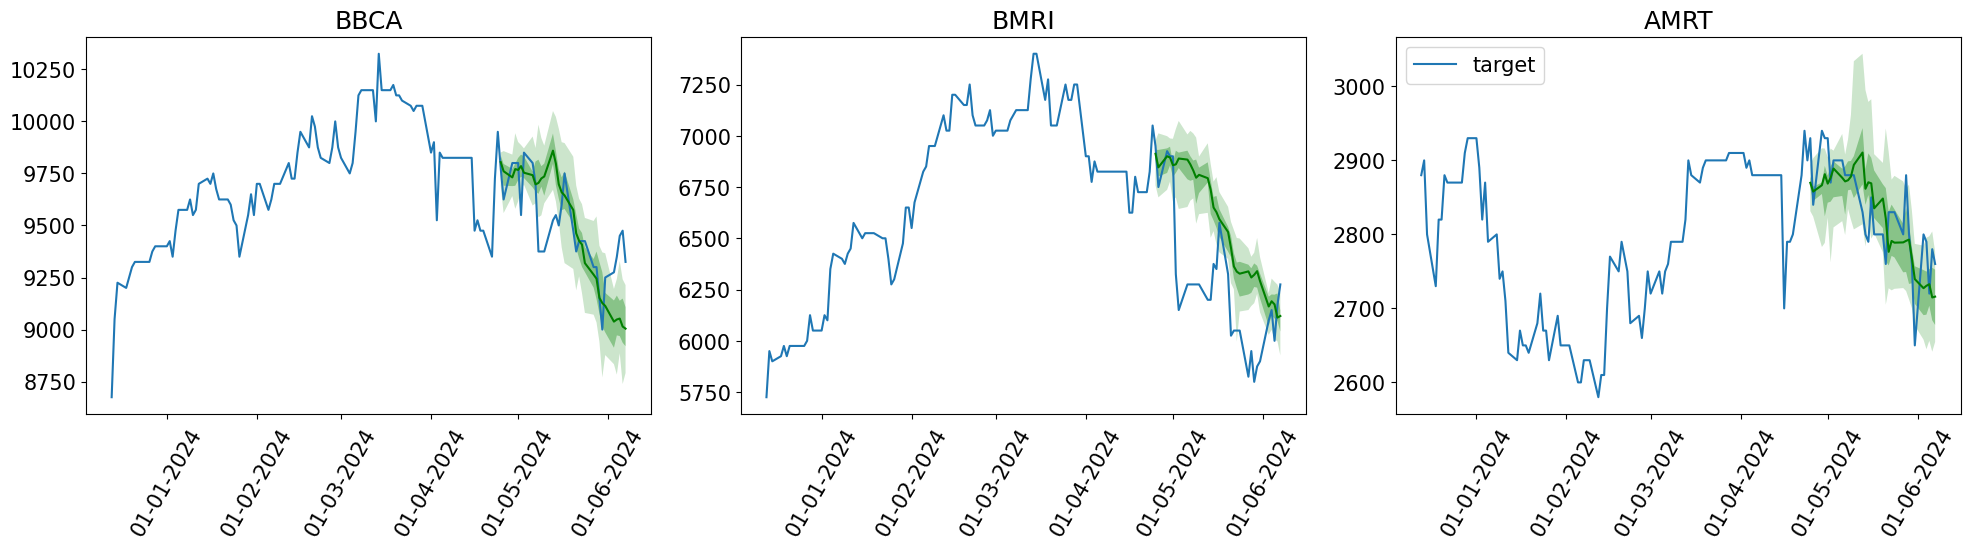

In [33]:
plotting(forecasts_fine_tuning_len_512_lr_5e_5, tss_fine_tuning_len_512_lr_5e_5)

### Get predictions with the default context length ***(1024)***

In [34]:
forecasts_fine_tuning_len_1024_lr_5e_5, tss_fine_tuning_len_1024_lr_5e_5, agg_metrics = lag_llama_fine_tuning(1024, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.66325 (best 6.66325), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_443\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.23269 (best 6.23269), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_443\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.20110 (best 6.20110), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_443\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.13594 (best 6.13594), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_443\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.08466 (best 6.08466), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_443\\checkpoints\\epoch=4-step=250.ckpt' as top

In [35]:
fine_tuning_len_1024_lr_5e_5 = print_crps_fine_tuning(1024, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 5e-05 CRPS: 0.0512


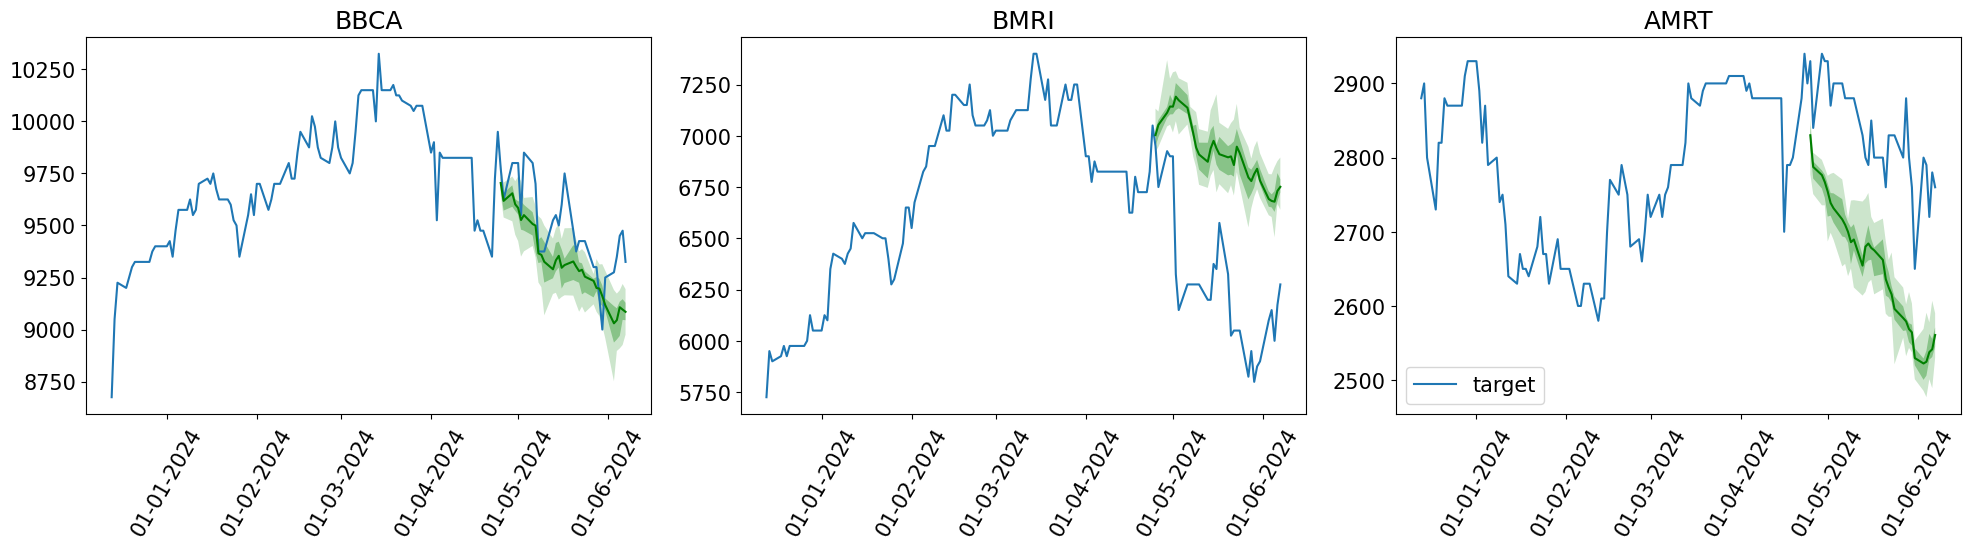

In [36]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_5, tss_fine_tuning_len_1024_lr_5e_5)

# **Compared to TFT and DeepAR**

In [121]:
tft_estimator = TemporalFusionTransformerEstimator(
    prediction_length=prediction_length,
    context_length=32,
    freq="B",
    batch_size=batch_size,
    trainer_kwargs={"max_epochs": epoch}
)
deepar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=32,
    freq="B",
    batch_size=batch_size,
    trainer_kwargs={"max_epochs": epoch}
)

In [122]:
tft_predictor = tft_estimator.train(backtrain_dataset)
deepar_predictor = deepar_estimator.train(backtrain_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                           | Params | In sizes                                                                           | Out sizes 
-----------------------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 109 K  | [[1, 32], [1, 32], [1, 1], [1, 1], [1, 64, 3], [1, 64, 0], [1, 32, 0], [1, 32, 0]] | [1, 9, 32]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.439     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8519.65527 (best 8519.65527), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_425\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7621.44043 (best 7621.44043), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_425\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6121.36084 (best 6121.36084), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_425\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5897.11914 (best 5897.11914), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_425\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 5700.87988 (bes

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.10524 (best 9.10524), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_426\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.59535 (best 7.59535), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_426\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.42870 (best 7.42870), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_426\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.34253 (best 7.34253), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_426\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.25284 (best 7.25284), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_426\\checkpoints\\epoch=4-step=250.ckpt' as top

In [123]:
tft_forecast_it, tft_ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=tft_predictor,
)

deepar_forecast_it, deepar_ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=deepar_predictor,
)

tft_forecasts = list(tft_forecast_it)
tft_tss = list(tft_ts_it)

deepar_forecasts = list(deepar_forecast_it)
deepar_tss = list(deepar_ts_it)

evaluator = Evaluator()
tft_agg_metrics, tft_ts_metrics = evaluator(iter(tft_tss), iter(tft_forecasts))
deepar_agg_metrics, deepar_ts_metrics = evaluator(iter(deepar_tss), iter(deepar_forecasts))


Running evaluation: 0it [00:00, ?it/s]The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
Running evaluation: 3it [00:00, 199.69it/s]

Running evaluation: 3it [00:00, 198.37it/s]


In [124]:
print(f"Temporal Fusion Transformer CRPS: {tft_agg_metrics['mean_wQuantileLoss']:.4f}")

Temporal Fusion Transformer CRPS: 0.0179


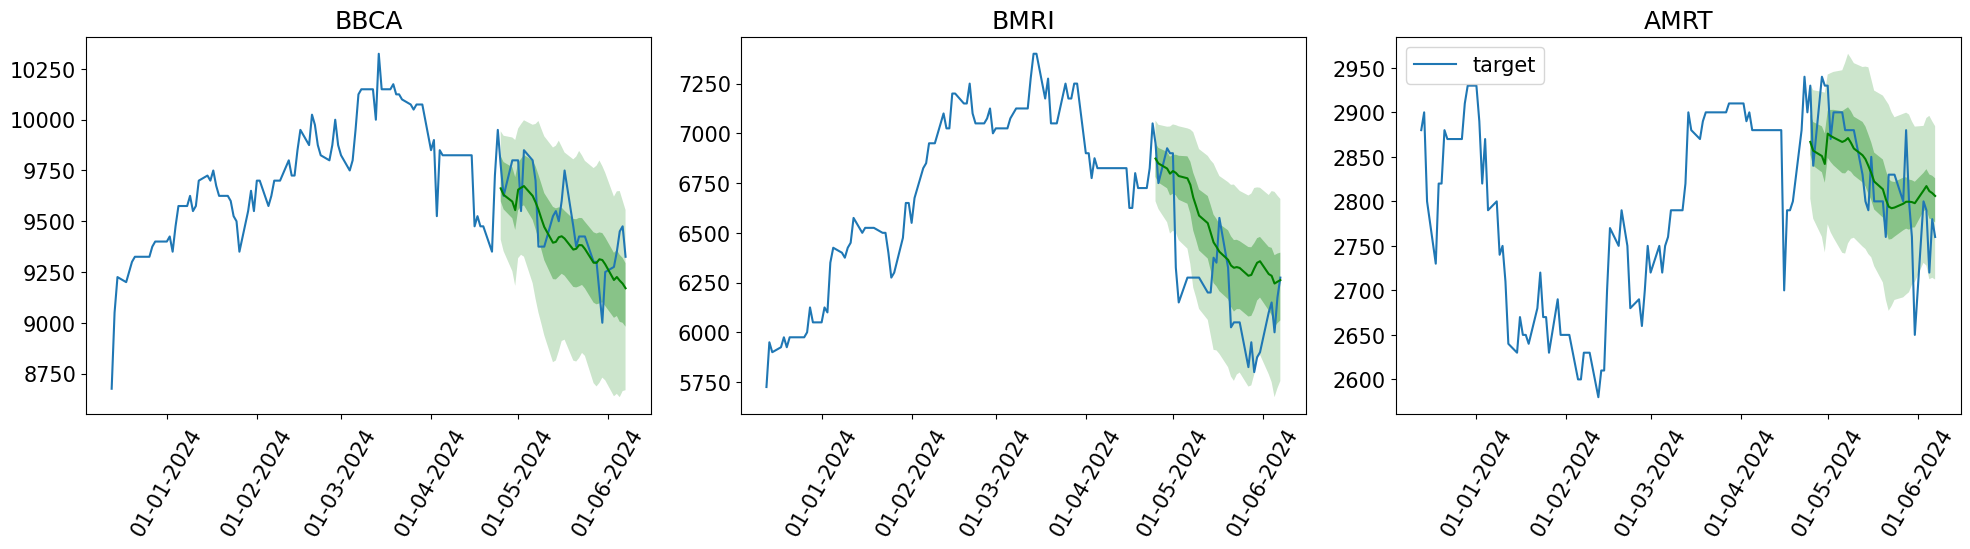

In [125]:
plotting(tft_forecasts, tft_tss)

In [126]:
print(f"DeepAR CRPS: {deepar_agg_metrics['mean_wQuantileLoss']:.4f}")

DeepAR CRPS: 0.0270


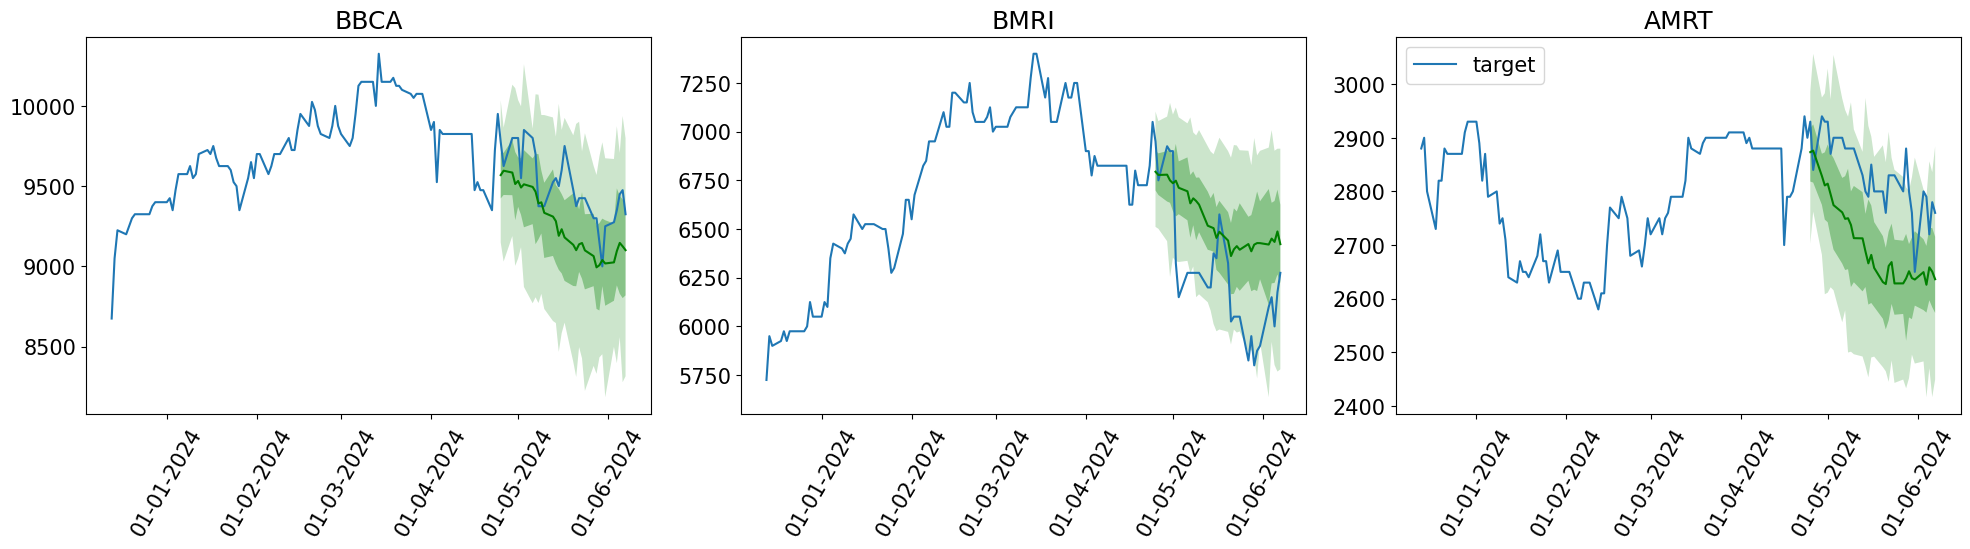

In [127]:
plotting(deepar_forecasts, deepar_tss)

# **Summary**

In [2]:
context_length = [32, 64, 128, 256, 512, 1024]
learning_rates = ['1e-2', '1e-3', '1e-4', '5e-3', '5e-4', '5e-5']

print("\n\033[1mLag-Llama Zero-Shot\033[0m")

# Lag-Llama Zero-Shot (False)
print("\n\033[1mRope scaled (False)\033[0m")
for length in context_length[:2]:
    print(f"Lag-Llama Zero-Shot ({length}) rope_scaled (False) CRPS: {globals()[f'zero_shot_len_{length}_false']:.4f}")

# Lag-Llama Zero-Shot (True)
print("\n\033[1mRope scaled (True)\033[0m")
for length in context_length[1:]:
    print(f"Lag-Llama Zero-Shot ({length}) rope_scaled (True) CRPS: {globals()[f'zero_shot_len_{length}_true']:.4f}")

# Lag-Llama Fine-Tuning
print("\n\033[1mLag-Llama Fine-Tuning\033[0m")
for lr in learning_rates:
    print(f"\n\033[1mLearning rate {lr}\033[0m")
    for length in context_length:
        variable_name = f"fine_tuning_len_{length}_lr_{lr.replace('-', '_')}"
        print(f"Lag-Llama Fine-Tuning ({length}) Lr {lr} CRPS: {globals()[variable_name]:.4f}")


print("\n\033[1mComparation Temporal Fusion Transformer (TFT) and DeepAR\033[0m")
print(f"Temporal Fusion Transformer CRPS: {tft_agg_metrics['mean_wQuantileLoss']:.4f}")
print(f"DeepAR CRPS: {deepar_agg_metrics['mean_wQuantileLoss']:.4f}")


Lag-Llama Zero-Shot

Rope scaled (False)
Lag-Llama Zero-Shot (32) rope_scaled (False) CRPS: 0.0364
Lag-Llama Zero-Shot (64) rope_scaled (False) CRPS: 0.0395

Rope scaled (True)
Lag-Llama Zero-Shot (64) rope_scaled (True) CRPS: 0.0417
Lag-Llama Zero-Shot (128) rope_scaled (True) CRPS: 0.0413
Lag-Llama Zero-Shot (256) rope_scaled (True) CRPS: 0.0379
Lag-Llama Zero-Shot (512) rope_scaled (True) CRPS: 0.0681
Lag-Llama Zero-Shot (1024) rope_scaled (True) CRPS: 0.1107

Lag-Llama Fine-Tuning

Learning rate 1e-2
Lag-Llama Fine-Tuning (32) Lr 1e-2 CRPS: 0.0195
Lag-Llama Fine-Tuning (64) Lr 1e-2 CRPS: 0.2130
Lag-Llama Fine-Tuning (128) Lr 1e-2 CRPS: 0.0928
Lag-Llama Fine-Tuning (256) Lr 1e-2 CRPS: 0.0445
Lag-Llama Fine-Tuning (512) Lr 1e-2 CRPS: 0.1919
Lag-Llama Fine-Tuning (1024) Lr 1e-2 CRPS: 0.0367

Learning rate 1e-3
Lag-Llama Fine-Tuning (32) Lr 1e-3 CRPS: 0.0327
Lag-Llama Fine-Tuning (64) Lr 1e-3 CRPS: 0.1018
Lag-Llama Fine-Tuning (128) Lr 1e-3 CRPS: 0.1898
Lag-Llama Fine-Tuning (256) Lr 

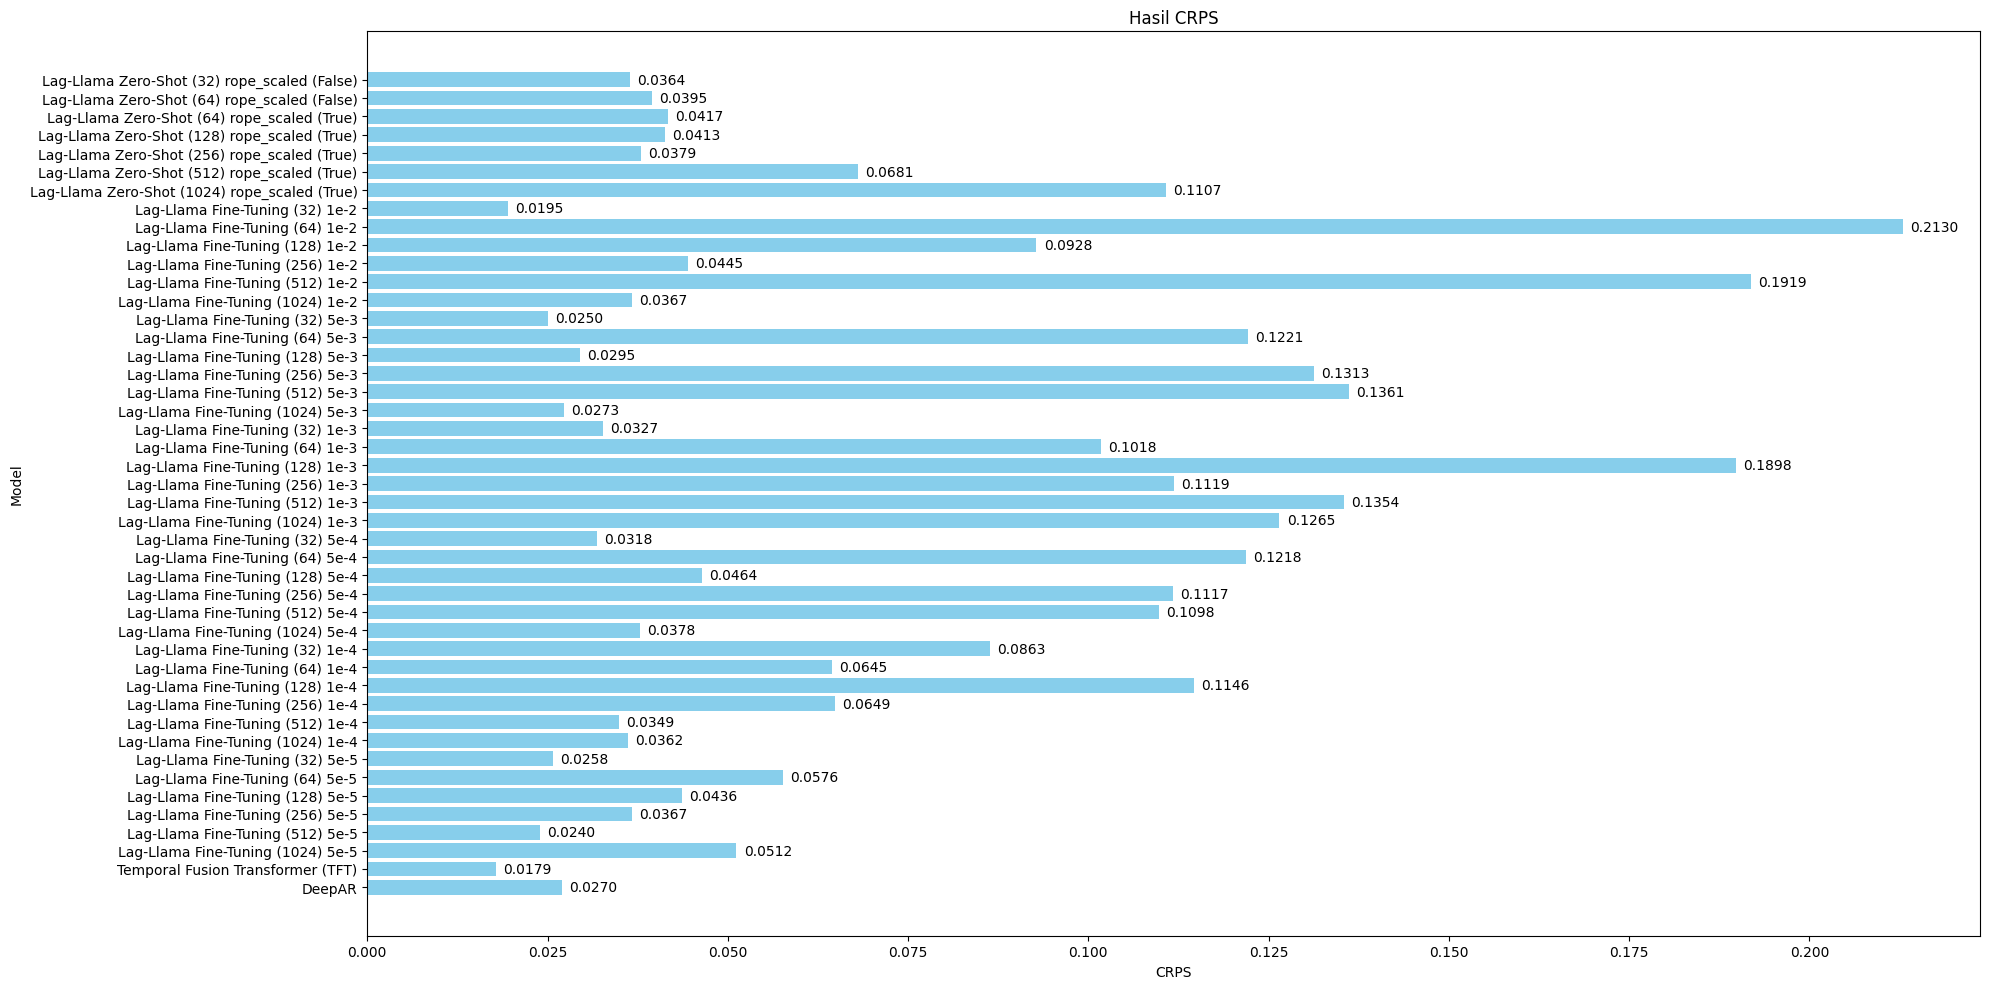

In [1]:
import matplotlib.pyplot as plt

def collect_crps_data(results):
    models, crps_values = [], []
    for model, data in results.items():
        if isinstance(data, dict):
            for sub_model, sub_data in data.items():
                for length, crps in sub_data.items():
                    models.append(f"{model} ({length}) {sub_model}")
                    crps_values.append(crps)
        else:
            models.append(model)
            crps_values.append(data)
    return models, crps_values

results = {
    "Lag-Llama Zero-Shot": {
        "Rope scaled (False)": {length: globals()[f'zero_shot_len_{length}_false'] for length in context_length[:2]},
        "Rope scaled (True)": {length: globals()[f'zero_shot_len_{length}_true'] for length in context_length[1:]}
    },
    "Lag-Llama Fine-Tuning": {
        lr: {length: globals()[f"fine_tuning_len_{length}_lr_{lr.replace('-', '_')}"] for length in context_length}
        for lr in learning_rates
    },
    "Temporal Fusion Transformer (TFT)": tft_agg_metrics['mean_wQuantileLoss'],
    "DeepAR": deepar_agg_metrics['mean_wQuantileLoss']
}

models, crps_values = collect_crps_data(results)
plt.figure(figsize=(32, 16))
bars = plt.barh(models, crps_values, color='skyblue')
plt.xlabel('CRPS')
plt.ylabel('Model')
plt.title('Hasil CRPS')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.4f}', va='center')

plt.tight_layout()
plt.show()

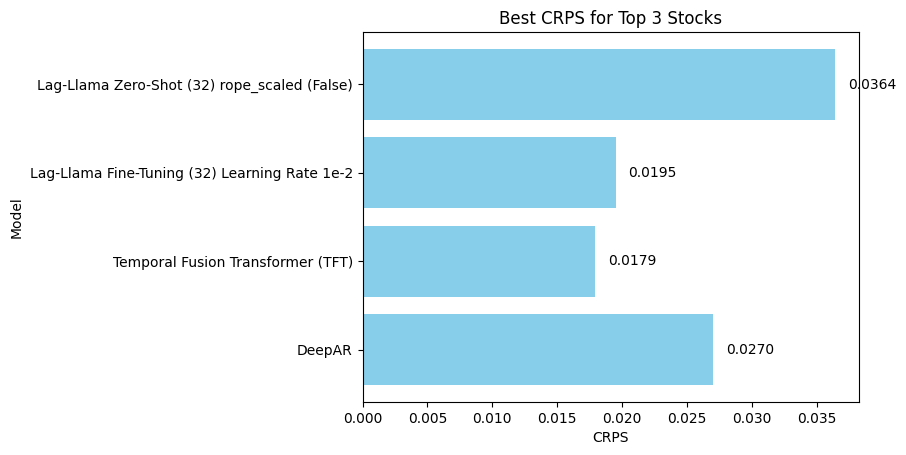

In [3]:
import matplotlib.pyplot as plt

data = {
    "Lag-Llama Zero-Shot (32) rope_scaled (False)": 0.0364,
    "Lag-Llama Fine-Tuning (32) Learning Rate 1e-2": 0.0195,
    "Temporal Fusion Transformer (TFT)": 0.0179,
    "DeepAR": 0.0270
}

models = list(data.keys())
crps_values = list(data.values())
fig, ax = plt.subplots()

bars = ax.barh(models, crps_values, color='skyblue')
plt.xlabel('CRPS')
plt.ylabel('Model')
plt.title('Best CRPS for Top 3 Stocks')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', va='center')

plt.show()